## Setup

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.stats import norm

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN

import keras
from keras import Sequential
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import SimpleRNN, GRU, LSTM, Dropout, Dense

In [2]:
plt.rcParams["figure.figsize"] = (14,5)

In [3]:
random_state = 441

## Prepare Data

In [4]:
data = pd.read_table('data/sensor-fault-detection.csv', sep=';')
data.drop('SensorId', axis=1, inplace=True) # SensorId column is not useful
data

Timestamp      Value
0      2017-03-01T23:20:00+03:00  18.479807
1      2017-03-02T04:00:00+03:00  19.539112
2      2017-03-23T06:25:00+03:00  19.250198
3      2017-03-23T19:35:00+03:00  18.961285
4      2017-04-04T15:10:00+03:00  25.321623
...                          ...        ...
62624  2017-05-05T17:00:00+03:00  24.743029
62625  2017-07-07T16:40:00+03:00  31.787771
62626  2017-05-07T09:20:00+03:00  26.382582
62627  2017-05-07T14:55:00+03:00  26.286133
62628  2017-05-07T20:40:00+03:00  26.671986

[62629 rows x 2 columns]

In [5]:
# Convert ISO 8601 string to datetime objects
data['Timestamp'] = data['Timestamp'].apply(lambda timestamp: dt.datetime.fromisoformat(timestamp))
data.set_index('Timestamp', inplace=True) # Save as index
data.sort_index(inplace=True) # Sort timestamps
data

Value
Timestamp                           
2016-08-01 01:00:00+03:00  27.636770
2016-08-01 02:00:00+03:00  27.250818
2016-08-01 03:00:00+03:00  27.154348
2016-08-01 04:00:00+03:00  26.768456
2016-08-01 08:00:00+03:00  25.418072
...                              ...
2017-09-01 00:35:00+03:00  21.754841
2017-09-01 00:40:00+03:00  21.562141
2017-09-01 00:45:00+03:00  21.465771
2017-09-01 00:50:00+03:00  21.562141
2017-09-01 00:55:00+03:00  21.465771

[62629 rows x 1 columns]

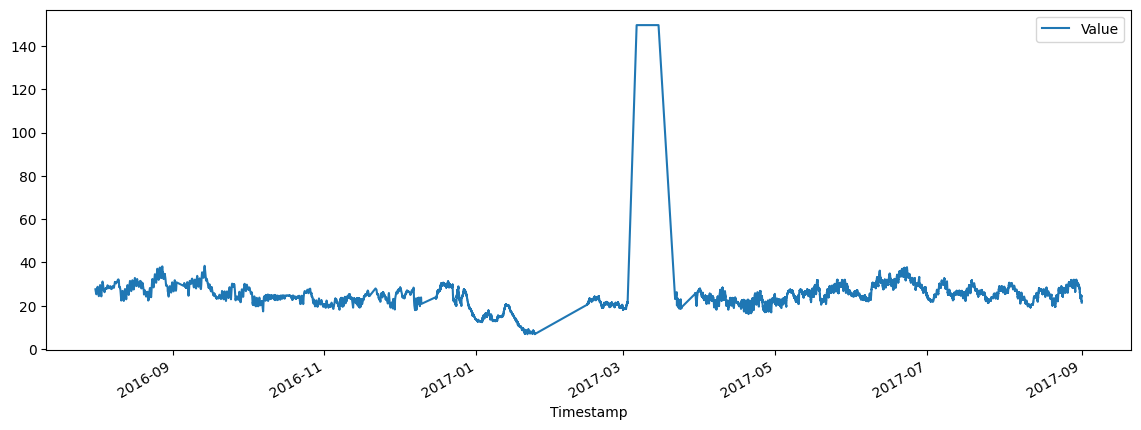

In [6]:
data.plot()
plt.show()

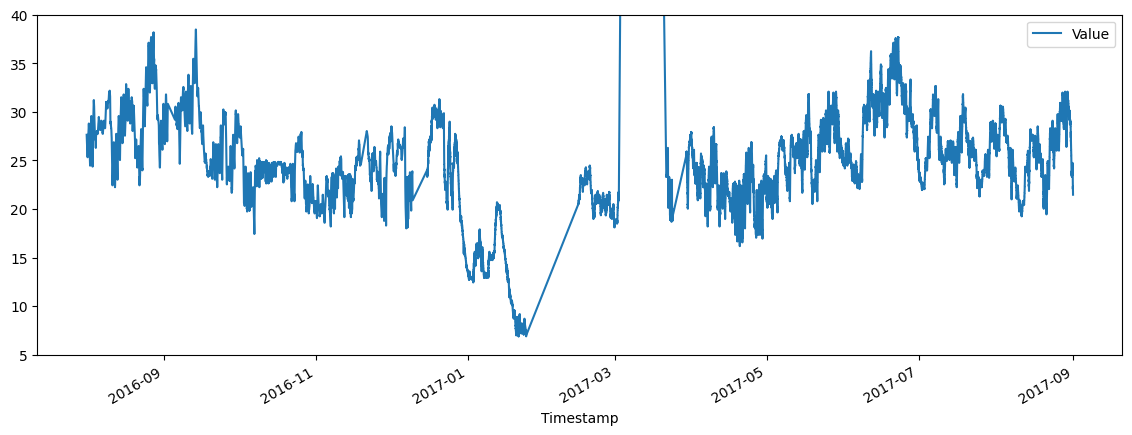

In [7]:
# Close-up...
data.plot()
plt.ylim((5,40))
plt.show()

More about the data:
- The data does not include values at even increments in time. Parts have values at every hour, at every 5 minutes, skipped for hours, or skipped for entire days.
- Most of the first portion of the data has recorded values for every hour, while later portions has it for every five minutes.
- Given the context behind the data, it is expected that there would be noise.

We define a point anomaly as any point that is radically different from its expected value.

In [8]:
# Show anomalies
data[data.values > 140]

Value
Timestamp                            
2017-03-06 07:50:00+03:00  149.601822
2017-03-06 19:10:00+03:00  149.601822
2017-03-07 13:00:00+03:00  149.601822
2017-03-08 03:10:00+03:00  149.601822
2017-03-12 03:00:00+03:00  149.601822
2017-03-14 03:50:00+03:00  149.601822
2017-03-14 04:00:00+03:00  149.601822
2017-03-15 02:45:00+03:00  149.601822

In [9]:
# Proportion of anomalies
anoms_prop = sum(data.values > 140)[0] / len(data)
anoms_prop

0.00012773635216912292

## Functions

In [10]:
def prepare_input_data(data, window:int):
    '''
    Prepare data to use as inputs for the models.

    Args:
        data: Input data
        window: Number of previous observations
    '''
    n = len(data)
    x = []
    for start in range(n-window):
        end = start + window
        x.append(data.values[start:end]) # Store previous values as X

    X = np.array(x).reshape(n-window, -1)
    y = data.values[window:].ravel()

    df = pd.DataFrame(X, index=data.index[window:])
    df['y'] = y
    return df

In [11]:
def plot_anoms(anoms:pd.Series, preds:pd.Series=None):
    data.plot(color='green') # Original data
    if preds is not None:
        preds.plot(label='Predicted Values', color='blue', alpha=0.5) # Predicted values
    plt.scatter(x='Timestamp', y='y', data=anoms, label='Anomalies',
                marker='x', color='red', alpha=0.8, zorder=10) # Anomalies
    plt.legend()


def plot_anoms_zscores(df:pd.DataFrame, preds:pd.Series, alpha=0.01):
    '''
    Predict anomalous data using z-scores and plot them over
    the original data and the predicted values.

    Args:
        df: The original input data with a 'y' column as the actual values
        preds: The predicted values
        alpha: Significance level
    '''
    resids = df['y'] - preds
    
    mean = np.mean(resids)
    std = np.std(resids)

    z_scores = [(x-mean) / std for x in resids]
    z_alpha = norm.ppf(1 - alpha/2)
    anomalies = df['y'][np.logical_or(z_scores > z_alpha, z_scores < -z_alpha)]
    print(f"{len(anomalies)} predicted anomalies")
    
    # Plot
    plot_anoms(anomalies.reset_index(), preds)
    plt.show()
    plot_anoms(anomalies.reset_index(), preds)
    plt.ylim(5,40)
    plt.show()


def plot_anoms_tukey(df:pd.DataFrame, preds:pd.Series, k=1.5):
    '''
    Predict anomalous data using Tukey's method and plot them over
    the original data and the predicted values.

    Args:
        df: The original input data with a 'y' column as the actual values
        preds: The predicted values
        k: Weight for outlier sensitivitiy
    '''
    resids = df['y'] - preds

    first_quartile = np.quantile(resids, 0.25)
    third_quartile = np.quantile(resids, 0.75)
    iqr = third_quartile - first_quartile

    anomalies = df['y'][np.logical_or(resids < first_quartile - k*iqr, resids > third_quartile + k*iqr)]
    print(f"{len(anomalies)} predicted anomalies")
    
    # Plot
    plot_anoms(anomalies.reset_index(), preds)
    plt.show()
    plot_anoms(anomalies.reset_index(), preds)
    plt.ylim(5,40)
    plt.show()

In [102]:
def train_clusterer(Xtrain, Xtest, model):
    model.fit(Xtrain)
    clusters = model.predict(Xtest)
    return clusters


def plot_anoms_clustering(df:pd.DataFrame, clusters, preds=None, clusters_to_plot:list=None):
    '''
    Plot anomalous data using clustering results over the original data and,
    optionally, the predicted values.

    Args:
        df: The original input data with a 'y' column as the actual values
        clusters: Clustering model output
        preds: Predicted values to plot; if None, it is not plotted
        clusters_to_plot: List of cluster names to plot; if None, the smallest cluster is plotted
    '''
    if clusters_to_plot is None:
        # Get label of the smallest cluster
        labels, counts = np.unique(clusters, return_counts=True)
        anom_label = labels[np.argmin(counts)]
        print(f"Anomalous cluster label: {anom_label}")

        # Get values in smallest cluster
        anomalies = df['y'][clusters == anom_label]
    else:
        # Get values in the clusters to plot
        anomalies = df['y'][clusters == clusters_to_plot[0]]
        if len(clusters_to_plot) > 1:
            for anom_label in clusters_to_plot[1:]:
                anomalies = pd.concat([
                    anomalies,
                    df['y'][clusters == anom_label]
                ])
    print(f"{len(anomalies)} predicted anomalies")

    # Plot
    plot_anoms(anomalies.reset_index(), preds)
    plt.show()
    plot_anoms(anomalies.reset_index(), preds)
    plt.ylim(5,40)
    plt.show()    

In [13]:
def train_regressor(df:pd.DataFrame, Xtrain, ytrain, model) -> pd.Series:
    '''
    Train regression model and return predictions using the original input data.

    Args:
        df: The original input data with a 'y' column as the actual values
        Xtrain: Training input
        ytrain: Training target values
        model: Regression model to train and predict with
    
    Returns:
        A pandas Series of predictions 
    '''
    model.fit(Xtrain, ytrain)
    preds = model.predict(df.drop('y', axis=1).values)
    preds = pd.Series(preds, index=df.index)
    return preds

In [14]:
def train_dl_model(model, Xtrain, ytrain, Xvalid, yvalid, epochs=500) -> keras.callbacks.History:
    '''
    Train deep learning model using training and validation data.

    Args:
        model: Deep learning model
        Xtrain: Input training data
        ytrain: Target training data
        Xvalid: Input validation data
        yvalid: Target validation data
    '''
    model.compile(optimizer='adam', 
                loss='mean_squared_error', 
                metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    callbacks = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=12)
    history = model.fit(Xtrain, ytrain,
                        shuffle=False, epochs=epochs,
                        batch_size=32,
                        validation_data=(Xvalid, yvalid),
                        callbacks=[callbacks], verbose=0)
    return history


def plot_dl_losses(history:keras.callbacks.History):
    '''
    Plot losses of the training and validation data from a
    trained deep learning model.
    '''
    x = range(len(history.history['loss']))
    plt.plot(x, history.history['loss'], color='black', label='Training Loss')
    plt.plot(x, history.history['val_loss'], color='red', label='Validation Loss')
    plt.legend()
    plt.show()

## Data to Anomaly Detection Pipeline

### Isolation Forest

In [110]:
df = prepare_input_data(data, window=0) # Include no previous values
df

y
Timestamp                           
2016-08-01 01:00:00+03:00  27.636770
2016-08-01 02:00:00+03:00  27.250818
2016-08-01 03:00:00+03:00  27.154348
2016-08-01 04:00:00+03:00  26.768456
2016-08-01 08:00:00+03:00  25.418072
...                              ...
2017-09-01 00:35:00+03:00  21.754841
2017-09-01 00:40:00+03:00  21.562141
2017-09-01 00:45:00+03:00  21.465771
2017-09-01 00:50:00+03:00  21.562141
2017-09-01 00:55:00+03:00  21.465771

[62629 rows x 1 columns]

Anomalous cluster label: -1
8 predicted anomalies


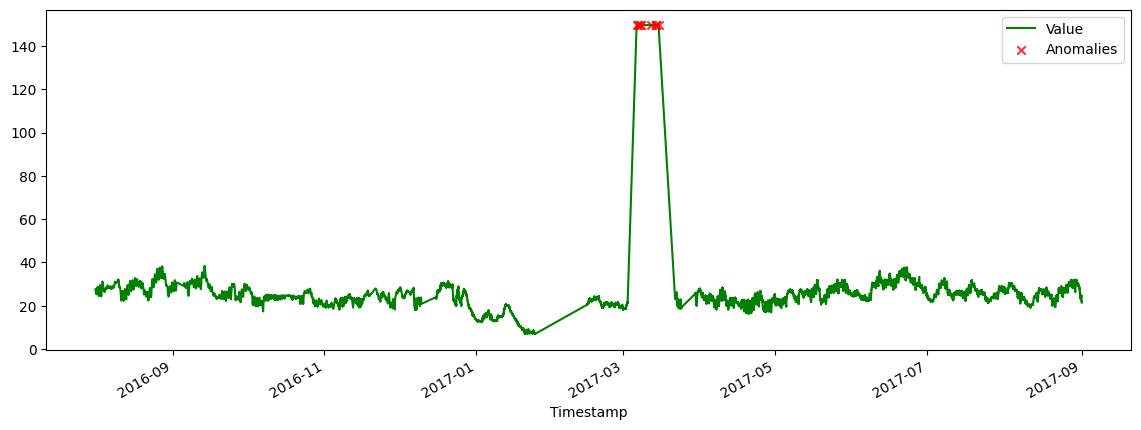

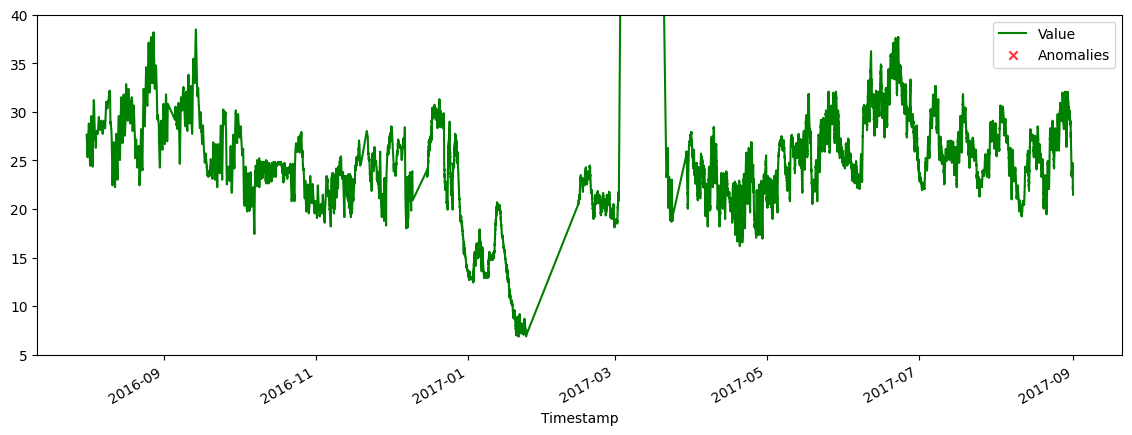

In [111]:
clusters = train_clusterer(df.values, df.values, IsolationForest(contamination=anoms_prop, random_state=random_state))
plot_anoms_clustering(df, clusters)

### K-Means Clustering

Anomalous cluster label: 4
8 predicted anomalies


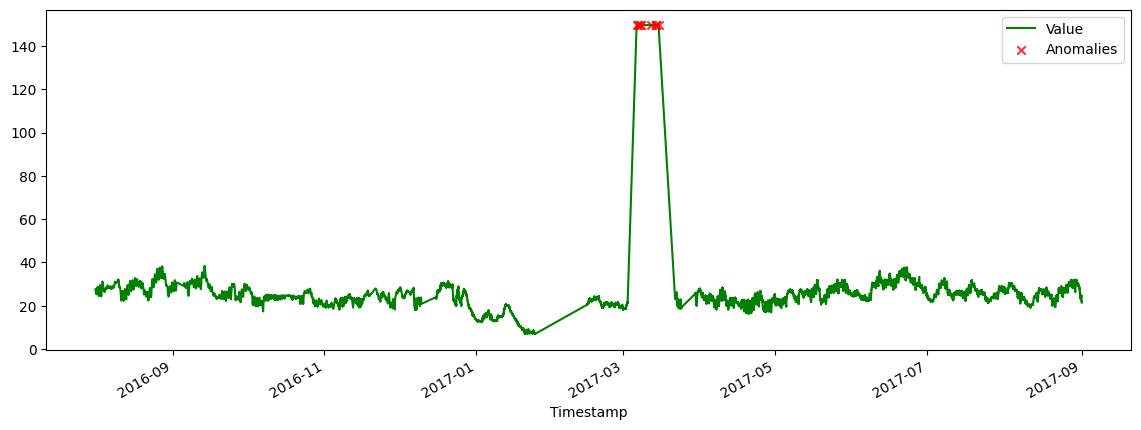

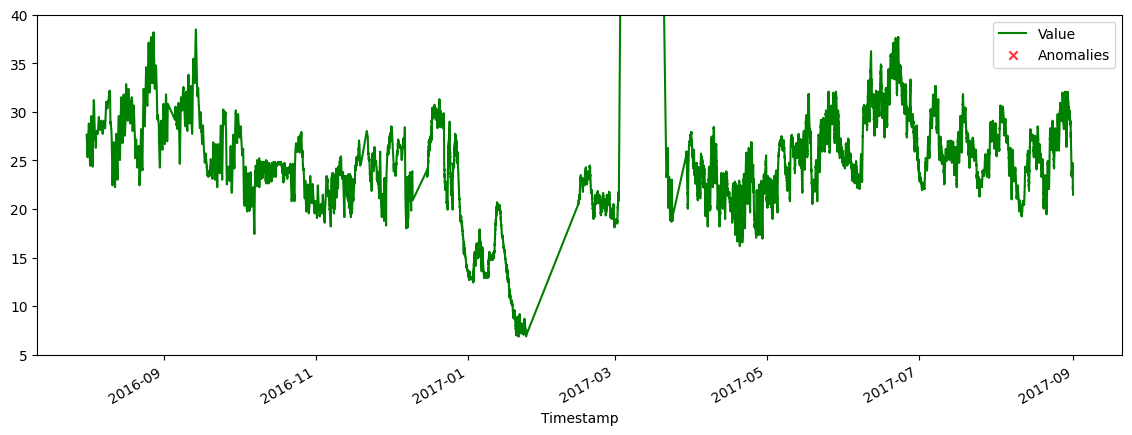

In [112]:
clusters = train_clusterer(df.values, df.values, KMeans(random_state=random_state))
plot_anoms_clustering(df, clusters)

### Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

Anomalous cluster label: 1
8 predicted anomalies


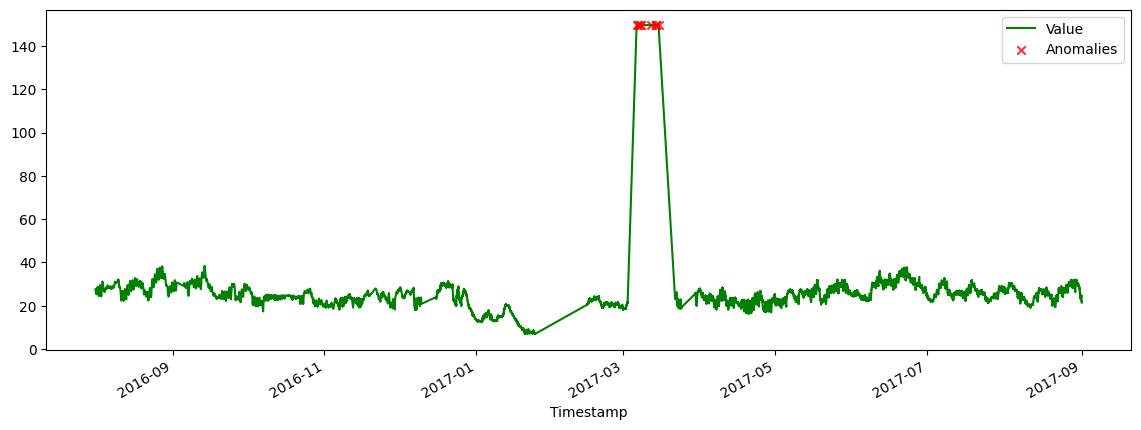

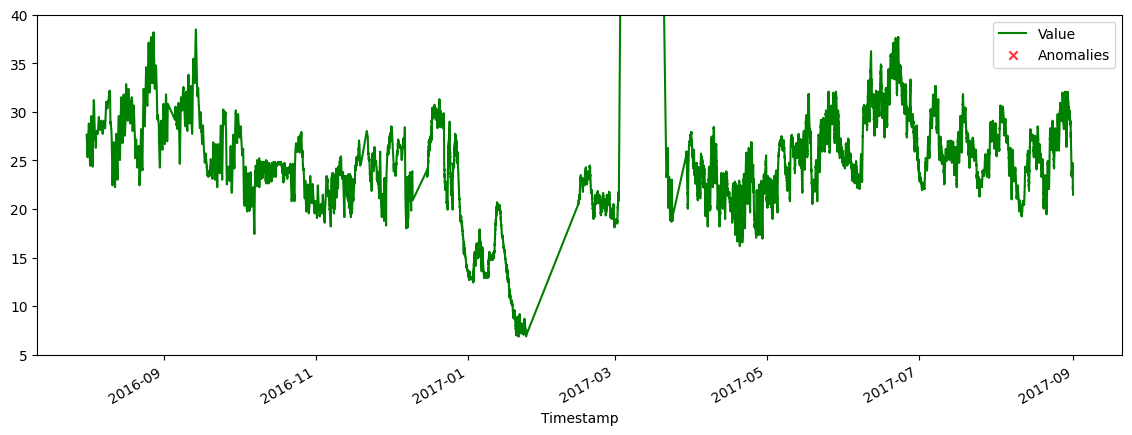

In [113]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(df.values)
plot_anoms_clustering(df, clusters)

## Data to Regression to Anomaly Detection Pipeline

###  Autoregressive Moving-Average (ARMA) Model

In [116]:
df = prepare_input_data(data, window=5)
df

0          1          2          3  \
Timestamp                                                               
2016-08-01 09:00:00+03:00  27.636770  27.250818  27.154348  26.768456   
2016-08-01 10:00:00+03:00  27.250818  27.154348  26.768456  25.418072   
2016-08-01 11:00:00+03:00  27.154348  26.768456  25.418072  25.418072   
2016-08-01 12:00:00+03:00  26.768456  25.418072  25.418072  25.321623   
2016-08-01 13:00:00+03:00  25.418072  25.418072  25.321623  25.514521   
...                              ...        ...        ...        ...   
2017-09-01 00:35:00+03:00  22.043932  21.851212  21.947582  21.851212   
2017-09-01 00:40:00+03:00  21.851212  21.947582  21.851212  21.658491   
2017-09-01 00:45:00+03:00  21.947582  21.851212  21.658491  21.754841   
2017-09-01 00:50:00+03:00  21.851212  21.658491  21.754841  21.562141   
2017-09-01 00:55:00+03:00  21.658491  21.754841  21.562141  21.465771   

                                   4          y  
Timestamp                                        
2016-08-01 09:00:00+03:00  25.418072  25.418072  
2016-08-01 10:00:00+03:00  25.418072  25.321623  
2016-08-01 11:00:00+03:00  25.321623  25.514521  
2016-08-01 12:00:00+03:00  25.514521  25.900297  
2016-08-01 13:00:00+03:00  25.900297  26.382582  
...                              ...        ...  
2017-09-01 00:35:00+03:00  21.658491  21.754841  
2017-09-01 00:40:00+03:00  21.754841  21.562141  
2017-09-01 00:45:00+03:00  21.562141  21.465771  
2017-09-01 00:50:00+03:00  21.465771  21.562141  
2017-09-01 00:55:00+03:00  21.562141  21.465771  

[62624 rows x 6 columns]

In [117]:
model = SARIMAX(endog=df['y'], exog=df.drop('y', axis=1), order=(1,0,1)).fit(disp=False, maxiter=200)

C:\Users\17573\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\17573\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [118]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                62624
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -68366.675
Date:                Fri, 10 May 2024   AIC                         136749.349
Time:                        11:02:24   BIC                         136821.709
Sample:                             0   HQIC                        136771.781
                              - 62624                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0568      0.001    -53.396      0.000      -0.059      -0.055
1             -0.0287      0.001    -23.205      0.000      -0.031      -0.026
2             -0.0412      0.002    -25.717      0.000      -0.044      -0.038
3             -0.0166      0.002     -8.436      0.000      -0.020      -0.013
4              1.1433      0.005    233.058      0.000       1.134       1.153
ar.L1          0.7868      0.006    142.689      0.000       0.776       0.798
ma.L1         -0.9718      0.001  -1215.352      0.000      -0.973      -0.970
sigma2         0.5183   7.89e-05   6570.991      0.000       0.518       0.518
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):     1817704724901.75
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            24.73
Prob(H) (two-sided):                  0.00   Kurtosis:                     26396.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

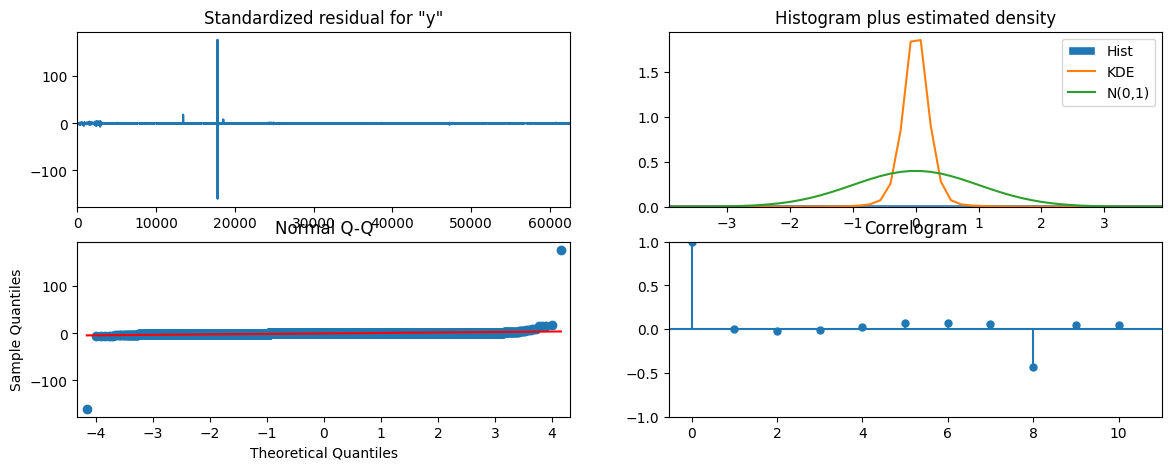

In [119]:
model.plot_diagnostics();

In [120]:
preds = model.predict()

62 predicted anomalies


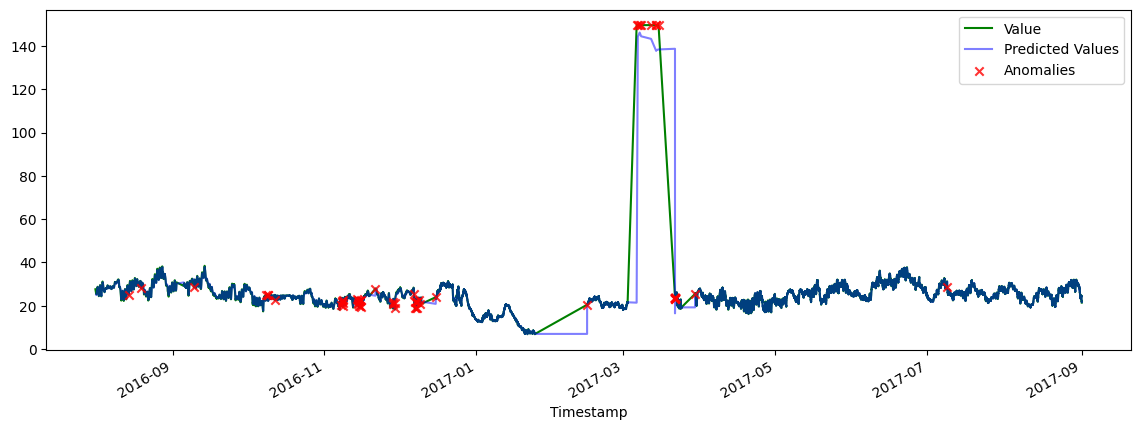

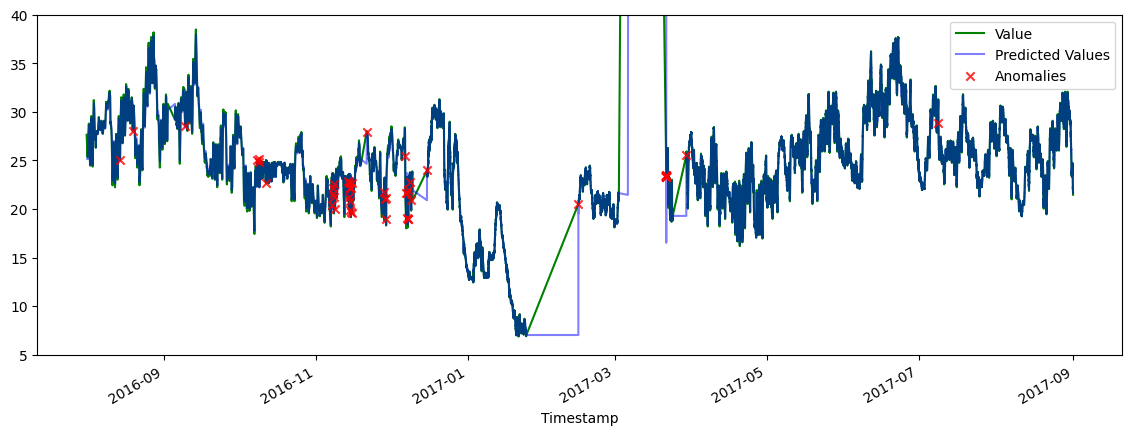

In [121]:
plot_anoms_zscores(df, preds)

16 predicted anomalies


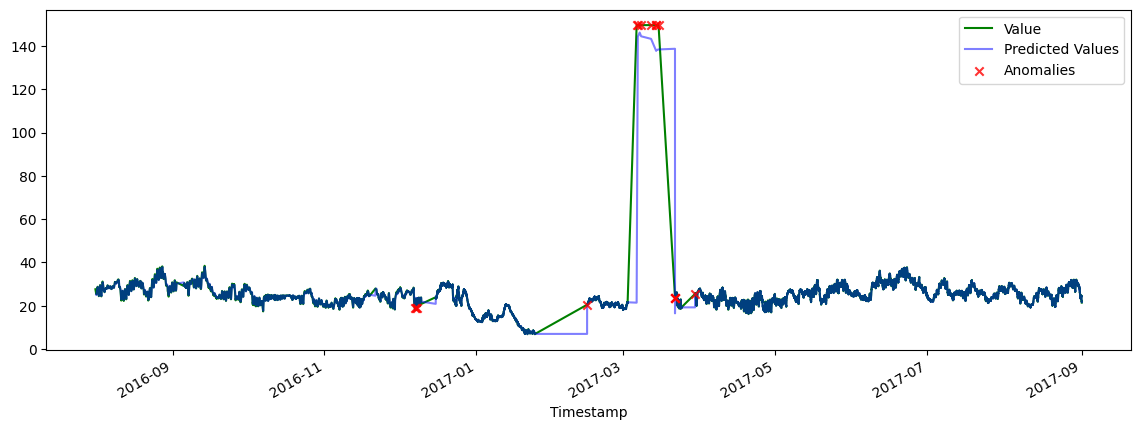

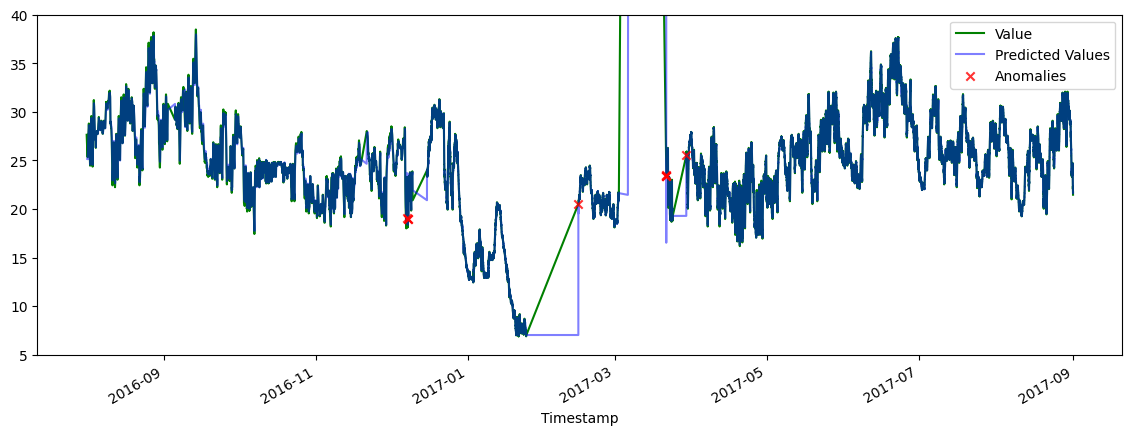

In [122]:
plot_anoms_tukey(df, preds, k=25)

In [123]:
# Combine actual values and predicted values
result = np.hstack([df['y'].values.reshape(-1,1), preds.values.reshape(-1,1)])
result

array([[25.41807175, 25.14495974],
       [25.32162285, 25.17927923],
       [25.51452065, 25.1309645 ],
       ...,
       [21.46577072, 21.70257546],
       [21.56214142, 21.60843776],
       [21.46577072, 21.70565012]])

Anomalous cluster label: -1
7 predicted anomalies


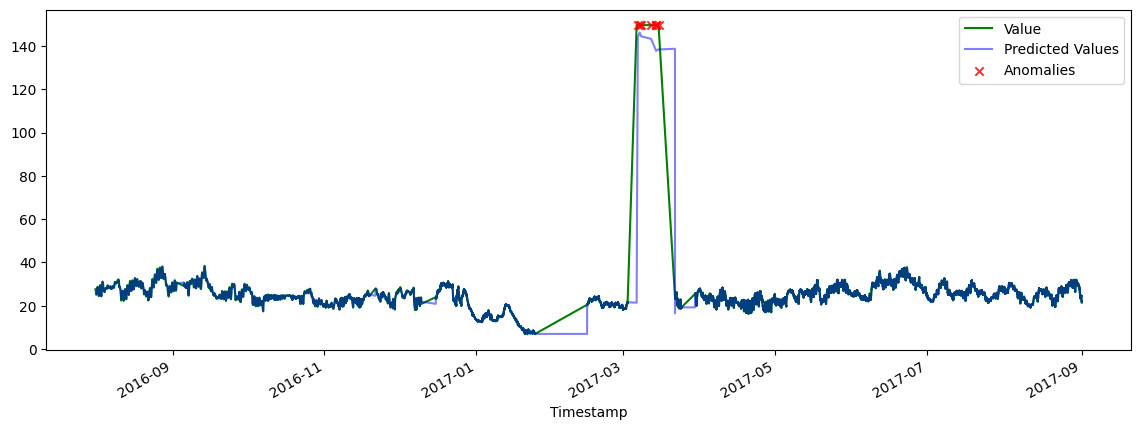

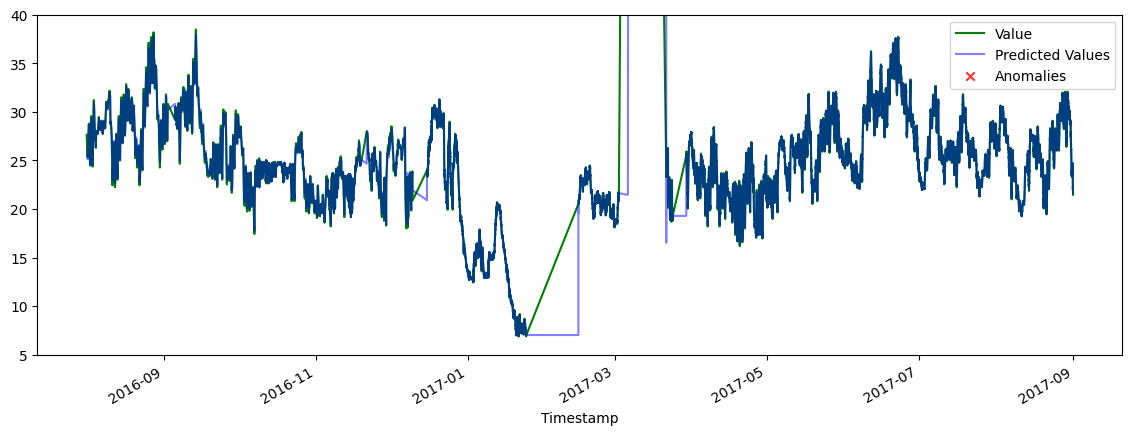

In [132]:
clusters = train_clusterer(result, result, IsolationForest(contamination=anoms_prop))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 4
8 predicted anomalies


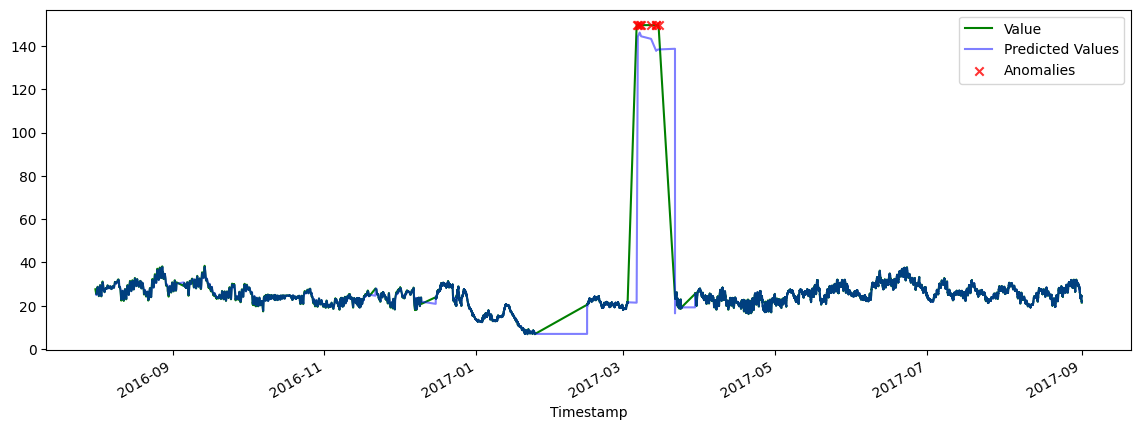

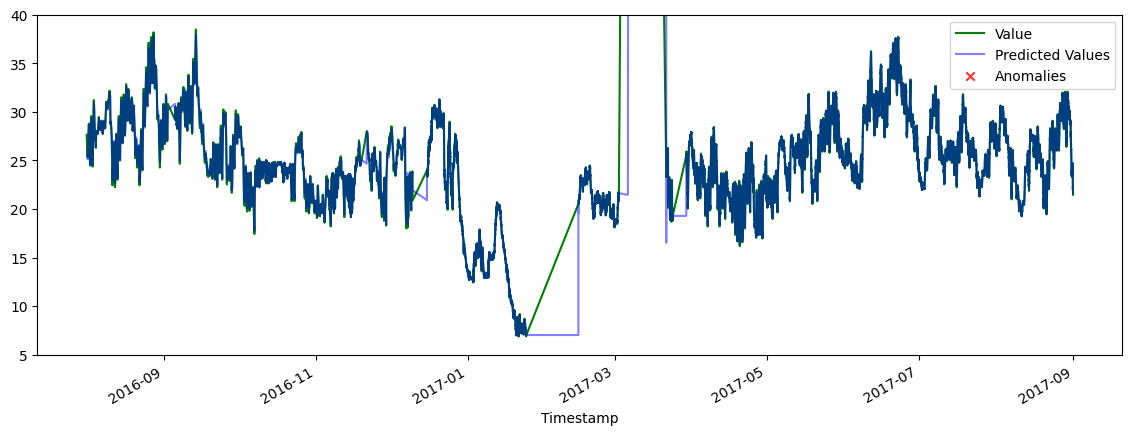

In [125]:
clusters = train_clusterer(result, result, KMeans(random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 1
8 predicted anomalies


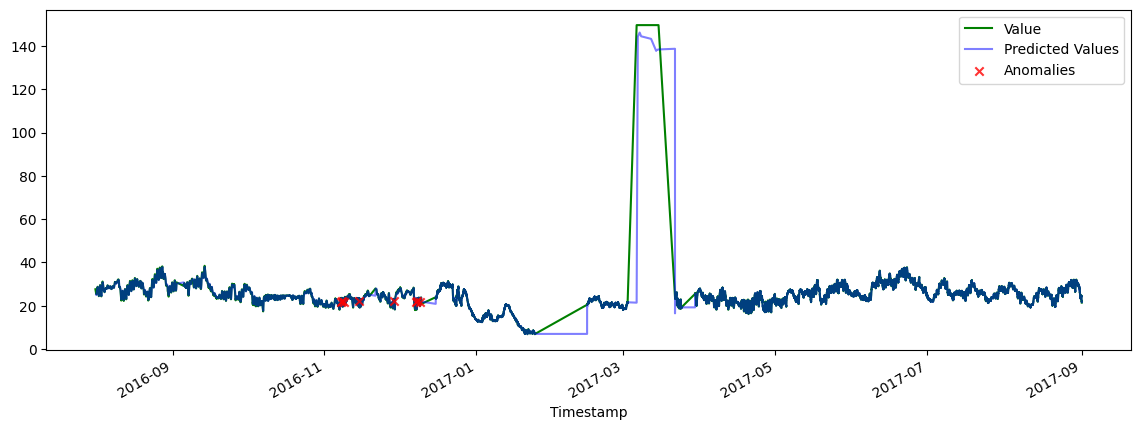

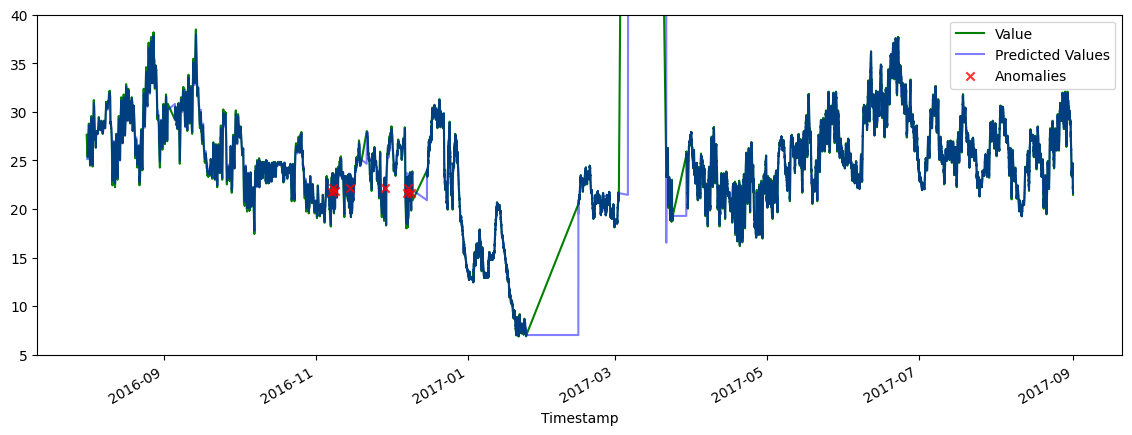

In [126]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(result)
plot_anoms_clustering(df, clusters, preds)

In [127]:
np.unique(clusters, return_counts=True)

(array([-1,  0,  1,  2], dtype=int64),
 array([   47, 61024,     8,  1545], dtype=int64))

In [128]:
# Missed the anomalous cluster
df['y'][np.logical_and(clusters == -1, df['y'] > 140)]

Timestamp
2017-03-06 07:50:00+03:00    149.601822
2017-03-06 19:10:00+03:00    149.601822
2017-03-07 13:00:00+03:00    149.601822
2017-03-08 03:10:00+03:00    149.601822
2017-03-12 03:00:00+03:00    149.601822
2017-03-14 03:50:00+03:00    149.601822
2017-03-14 04:00:00+03:00    149.601822
2017-03-15 02:45:00+03:00    149.601822
Name: y, dtype: float64

55 predicted anomalies


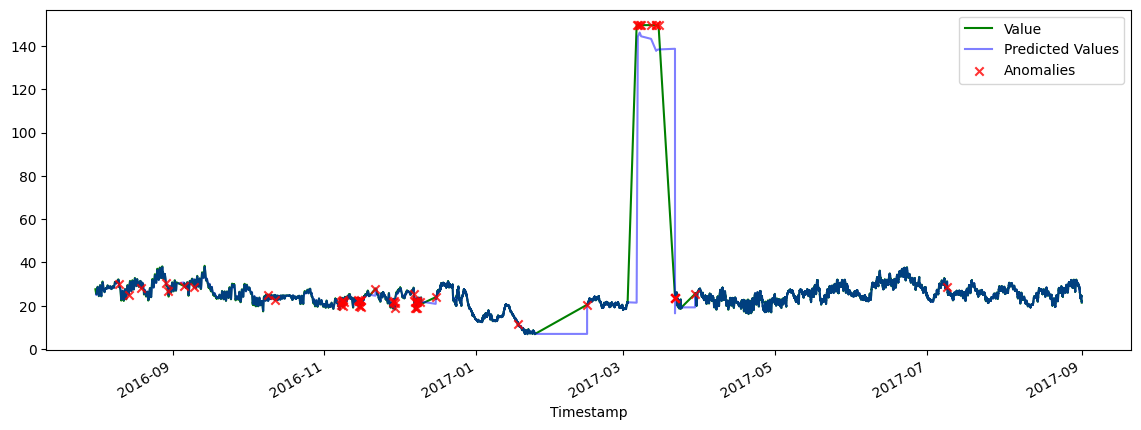

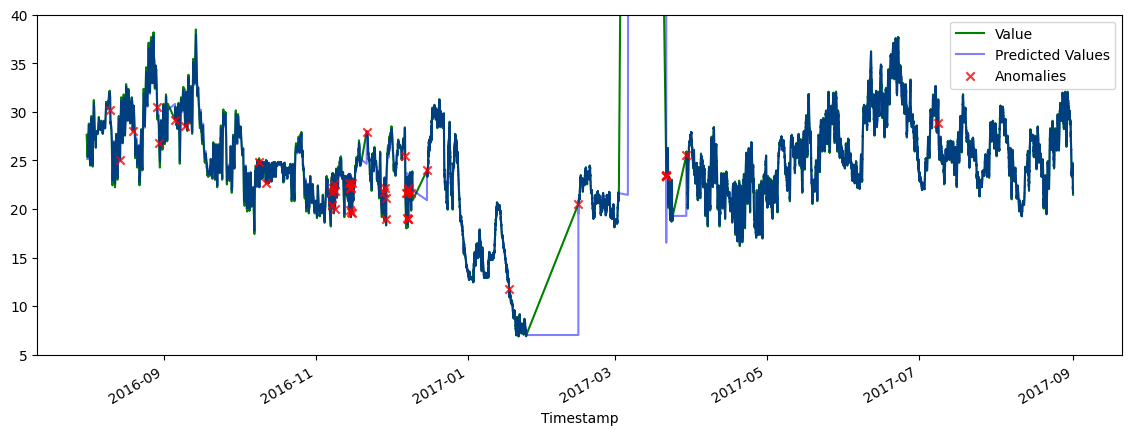

In [129]:
# Suppose we plot all clusters of size <50
plot_anoms_clustering(df, clusters, preds, clusters_to_plot=[-1,1])

### Machine Learning Regressors

#### Random Forest Regressor

In [176]:
df = prepare_input_data(data, window=10)
df

0          1          2          3  \
Timestamp                                                               
2016-08-01 14:00:00+03:00  27.636770  27.250818  27.154348  26.768456   
2016-08-01 15:00:00+03:00  27.250818  27.154348  26.768456  25.418072   
2016-08-01 16:00:00+03:00  27.154348  26.768456  25.418072  25.418072   
2016-08-01 17:00:00+03:00  26.768456  25.418072  25.418072  25.321623   
2016-08-01 18:00:00+03:00  25.418072  25.418072  25.321623  25.514521   
...                              ...        ...        ...        ...   
2017-09-01 00:35:00+03:00  22.333044  22.140303  22.140303  22.043932   
2017-09-01 00:40:00+03:00  22.140303  22.140303  22.043932  21.947582   
2017-09-01 00:45:00+03:00  22.140303  22.043932  21.947582  22.043932   
2017-09-01 00:50:00+03:00  22.043932  21.947582  22.043932  21.851212   
2017-09-01 00:55:00+03:00  21.947582  22.043932  21.851212  21.947582   

                                   4          5          6          7  \
Timestamp                                                               
2016-08-01 14:00:00+03:00  25.418072  25.418072  25.321623  25.514521   
2016-08-01 15:00:00+03:00  25.418072  25.321623  25.514521  25.900297   
2016-08-01 16:00:00+03:00  25.321623  25.514521  25.900297  26.382582   
2016-08-01 17:00:00+03:00  25.514521  25.900297  26.382582  26.671986   
2016-08-01 18:00:00+03:00  25.900297  26.382582  26.671986  27.057861   
...                              ...        ...        ...        ...   
2017-09-01 00:35:00+03:00  21.947582  22.043932  21.851212  21.947582   
2017-09-01 00:40:00+03:00  22.043932  21.851212  21.947582  21.851212   
2017-09-01 00:45:00+03:00  21.851212  21.947582  21.851212  21.658491   
2017-09-01 00:50:00+03:00  21.947582  21.851212  21.658491  21.754841   
2017-09-01 00:55:00+03:00  21.851212  21.658491  21.754841  21.562141   

                                   8          9          y  
Timestamp                                                   
2016-08-01 14:00:00+03:00  25.900297  26.382582  26.671986  
2016-08-01 15:00:00+03:00  26.382582  26.671986  27.057861  
2016-08-01 16:00:00+03:00  26.671986  27.057861  27.250818  
2016-08-01 17:00:00+03:00  27.057861  27.250818  27.540283  
2016-08-01 18:00:00+03:00  27.250818  27.540283  27.829746  
...                              ...        ...        ...  
2017-09-01 00:35:00+03:00  21.851212  21.658491  21.754841  
2017-09-01 00:40:00+03:00  21.658491  21.754841  21.562141  
2017-09-01 00:45:00+03:00  21.754841  21.562141  21.465771  
2017-09-01 00:50:00+03:00  21.562141  21.465771  21.562141  
2017-09-01 00:55:00+03:00  21.465771  21.562141  21.465771  

[62619 rows x 11 columns]

In [177]:
train, test = train_test_split(df, test_size=0.8, shuffle=False)
Xtrain = train.drop('y', axis=1).values
ytrain = train['y'].values

In [178]:
preds = train_regressor(df, Xtrain, ytrain, RandomForestRegressor(random_state=random_state))

12 predicted anomalies


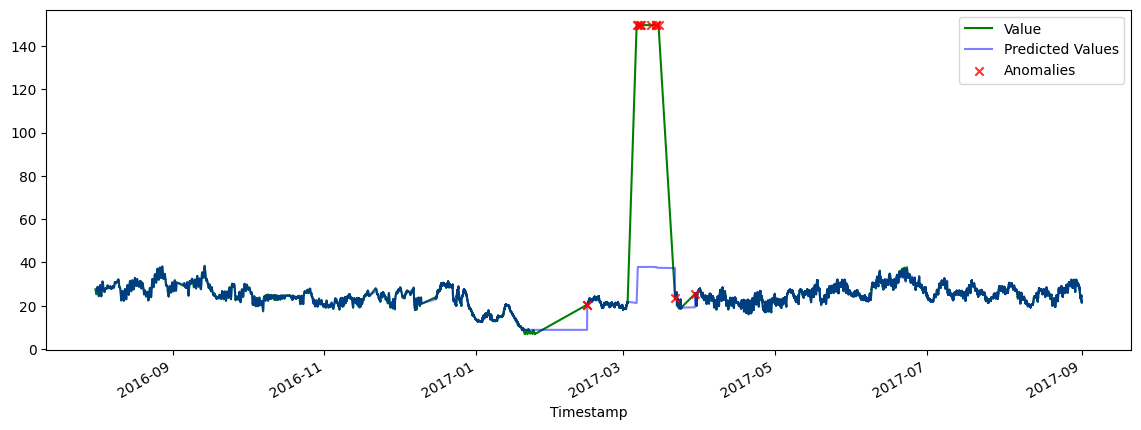

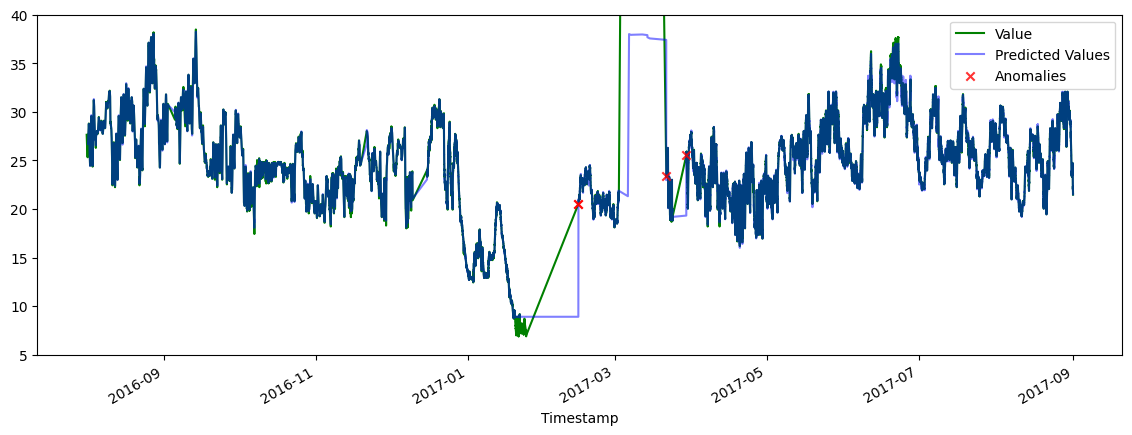

In [179]:
plot_anoms_zscores(df, preds)

12 predicted anomalies


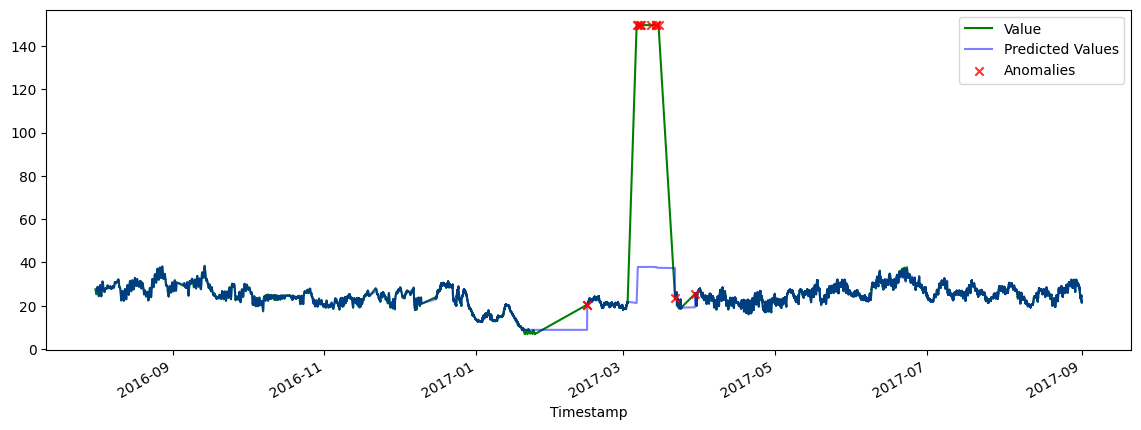

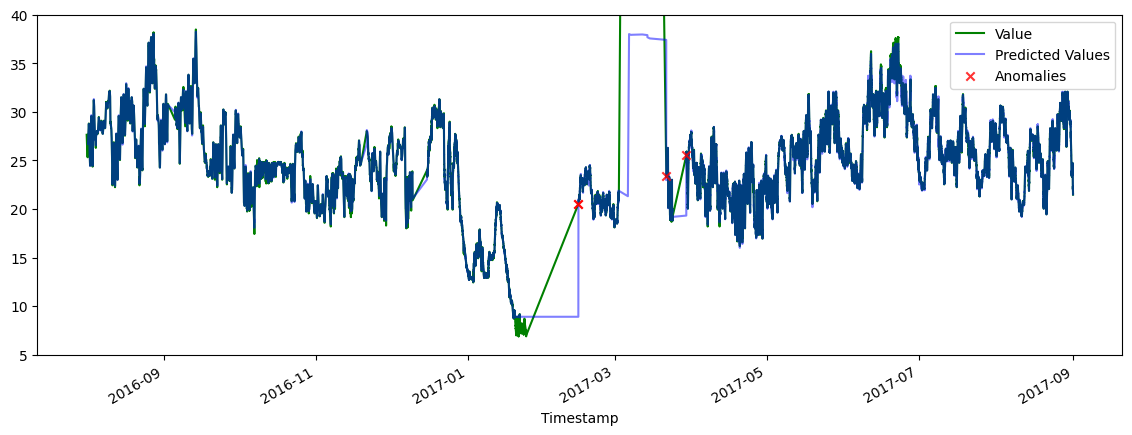

In [180]:
plot_anoms_tukey(df, preds, k=25)

In [181]:
# Combine actual values and predicted values
result = np.hstack([df['y'].values.reshape(-1,1), preds.values.reshape(-1,1)])
result

array([[26.67198563, 26.6893515 ],
       [27.05786133, 26.97393908],
       [27.25081825, 27.32511982],
       ...,
       [21.46577072, 21.53804647],
       [21.56214142, 21.4763789 ],
       [21.46577072, 21.54478824]])

Anomalous cluster label: -1
7 predicted anomalies


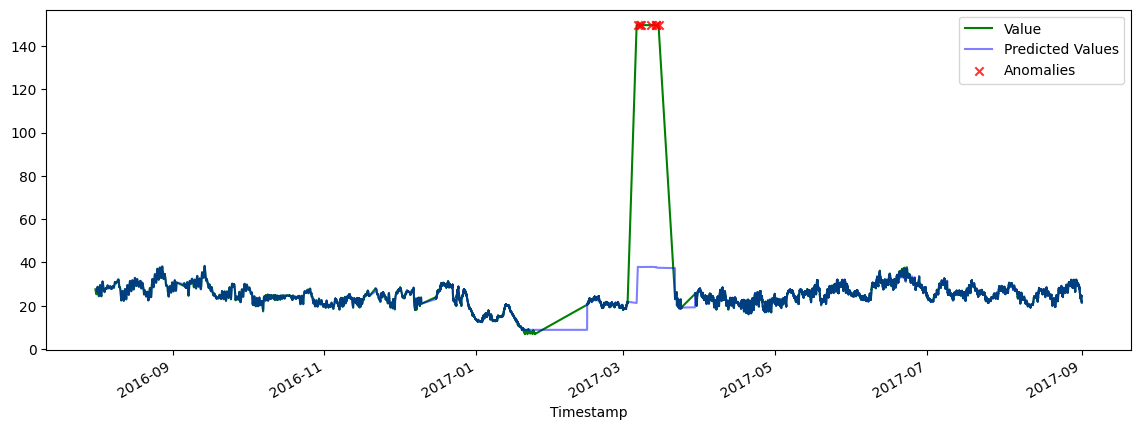

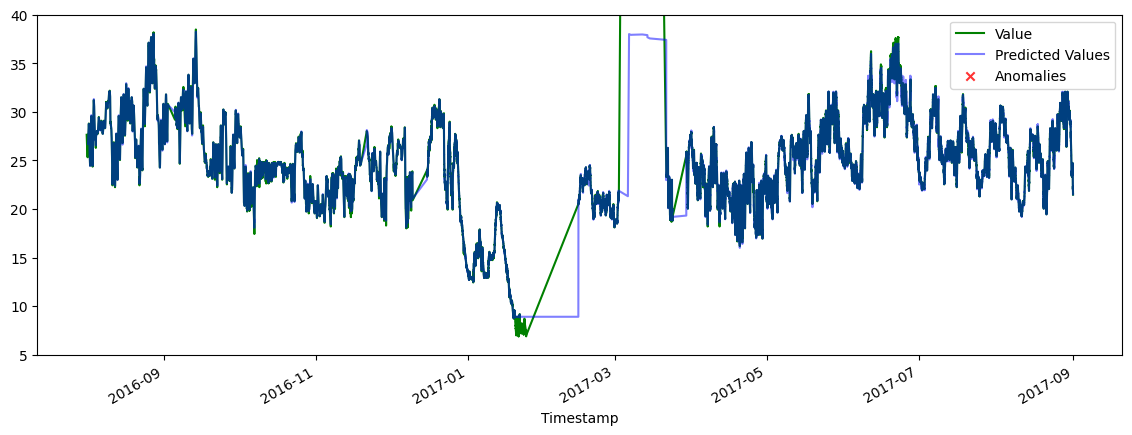

In [182]:
clusters = train_clusterer(result, result, IsolationForest(contamination=anoms_prop, random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 5
8 predicted anomalies


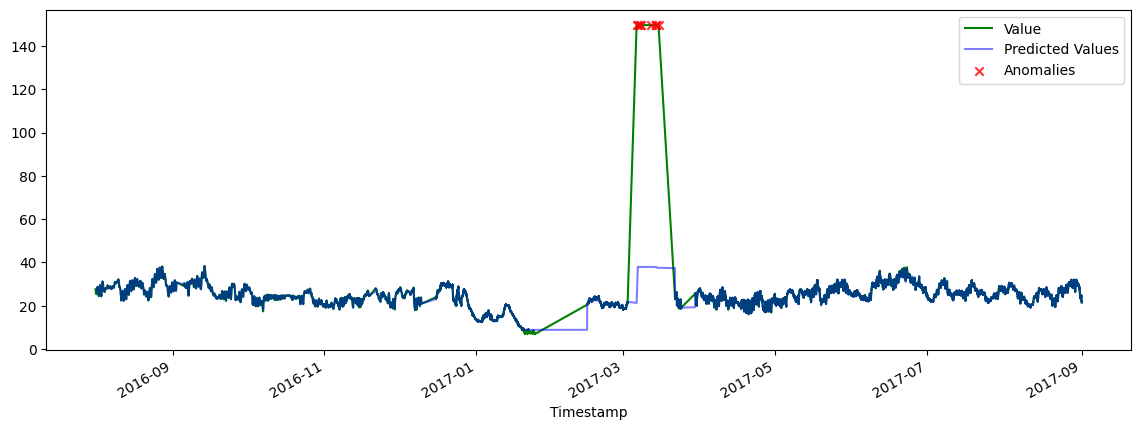

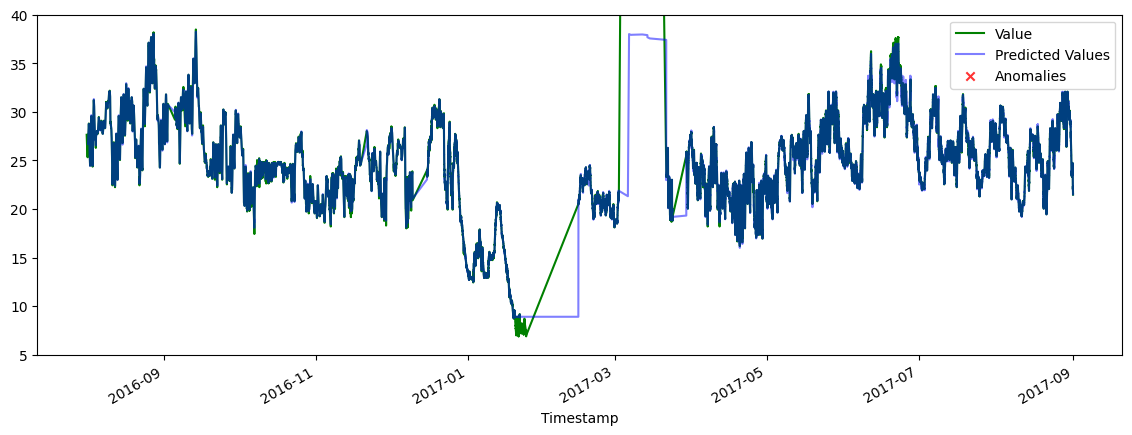

In [183]:
clusters = train_clusterer(result, result, KMeans(random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 2
7 predicted anomalies


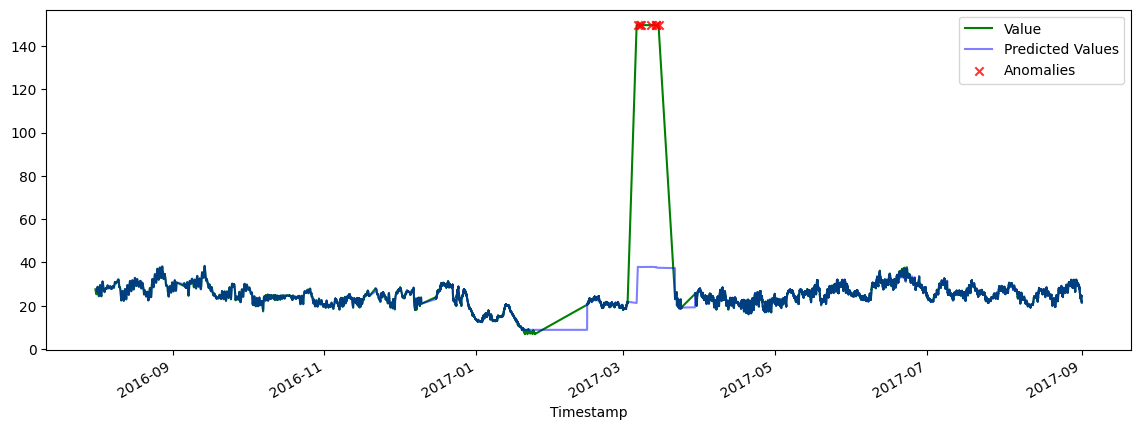

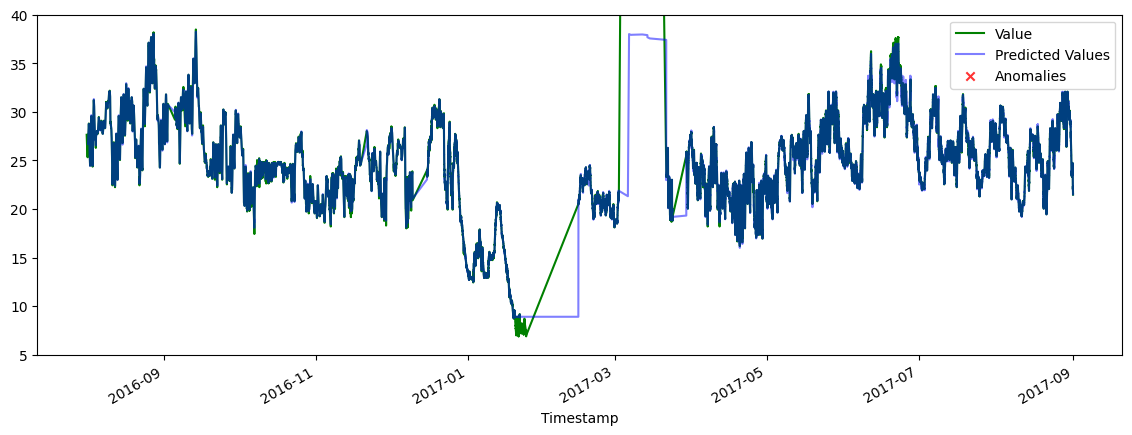

In [184]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(result)
plot_anoms_clustering(df, clusters, preds)

In [186]:
np.unique(clusters, return_counts=True)

(array([-1,  0,  1,  2], dtype=int64),
 array([    9, 61057,  1546,     7], dtype=int64))

In [187]:
# Missed one anomaly
df['y'][np.logical_and(clusters == -1, df['y'] > 140)]

Timestamp
2017-03-06 07:50:00+03:00    149.601822
Name: y, dtype: float64

16 predicted anomalies


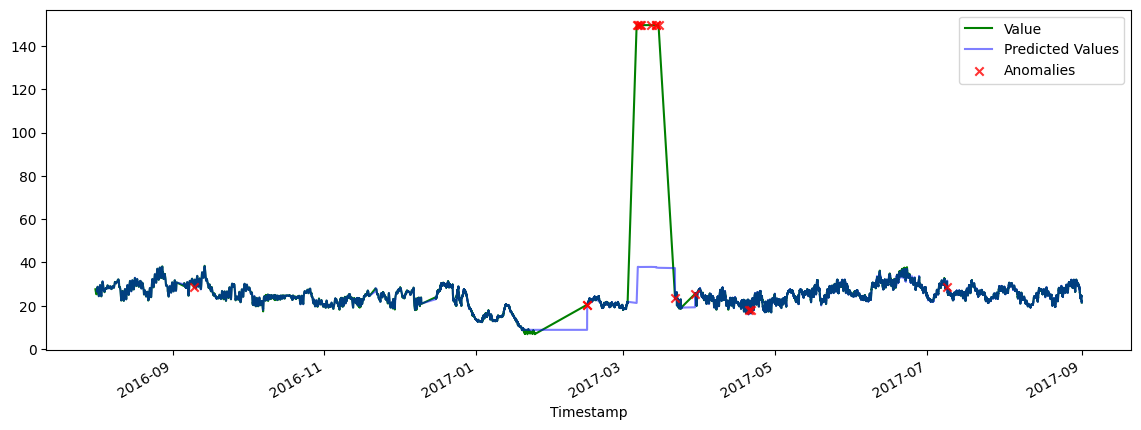

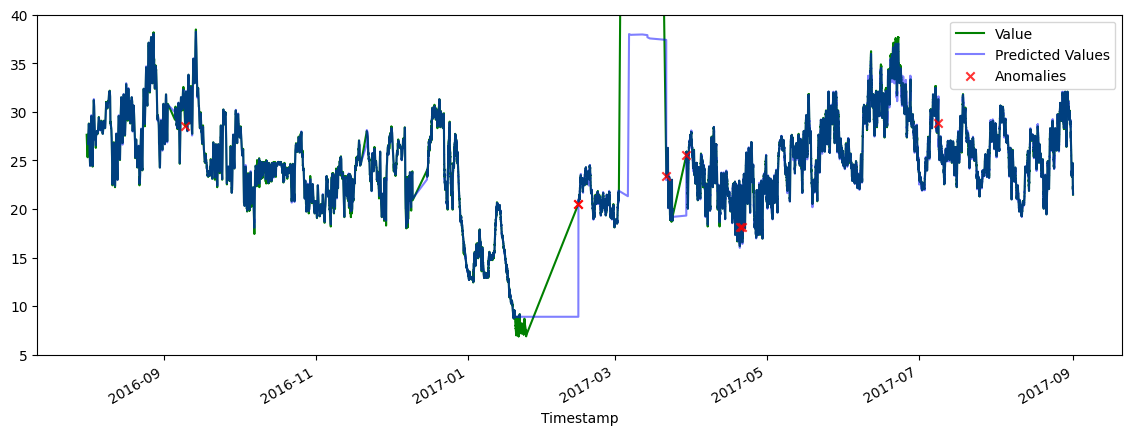

In [188]:
# Suppose we plot all clusters of size <10
plot_anoms_clustering(df, clusters, preds, clusters_to_plot=[-1,2])

#### Gradient Boosted Regressor

In [189]:
preds = train_regressor(df, Xtrain, ytrain, GradientBoostingRegressor(random_state=random_state))

11 predicted anomalies


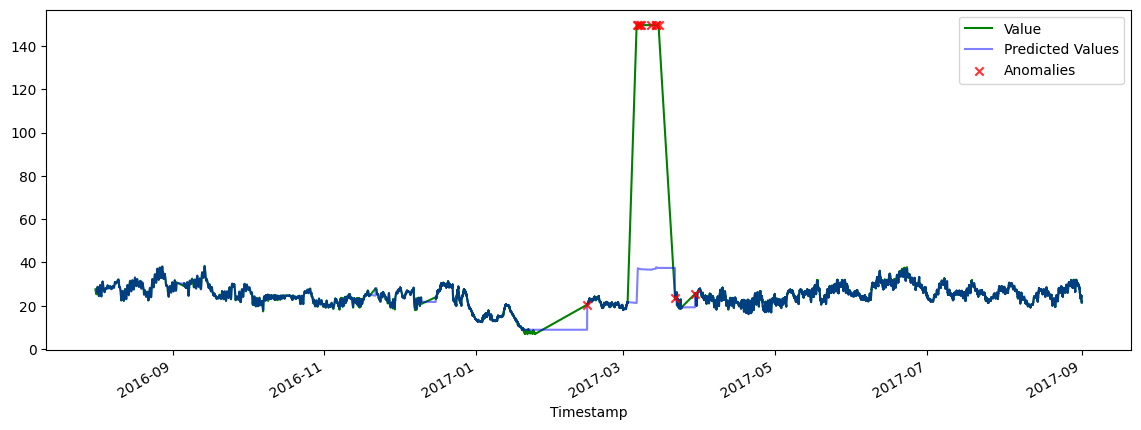

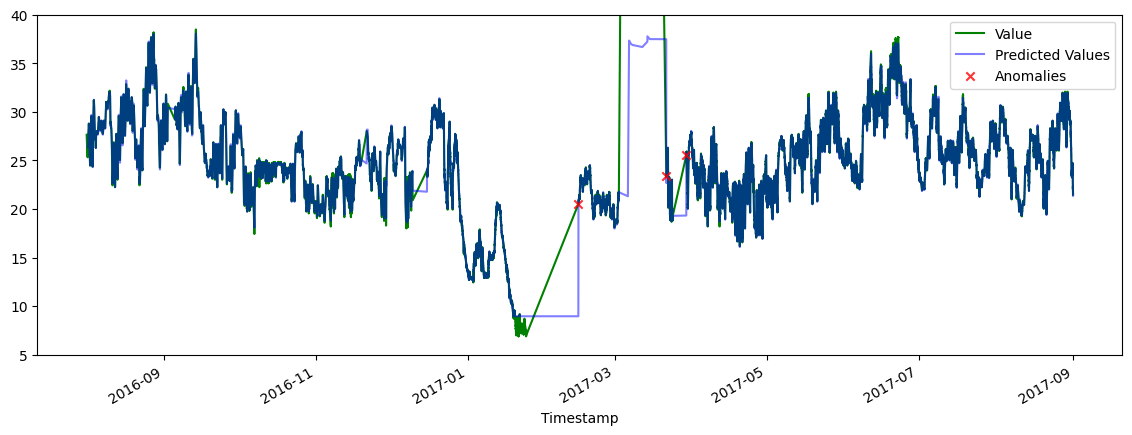

In [190]:
plot_anoms_zscores(df, preds)

11 predicted anomalies


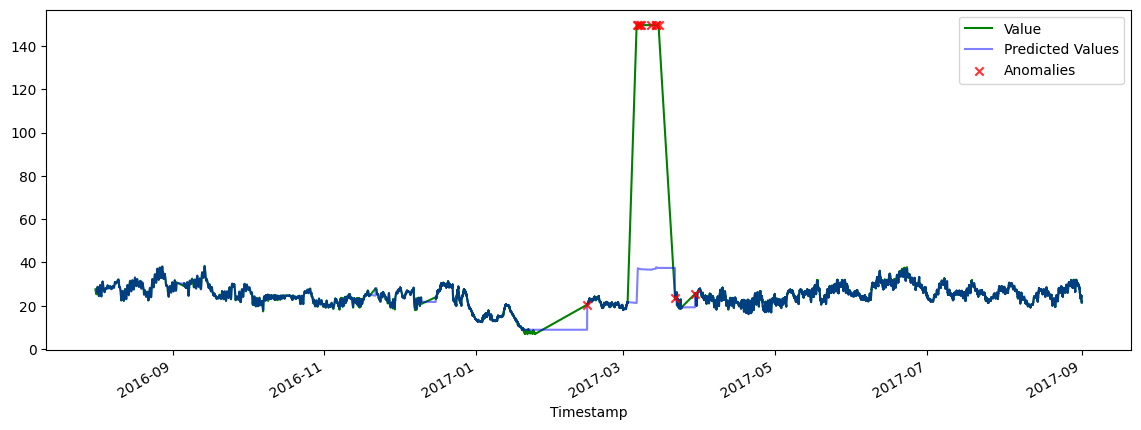

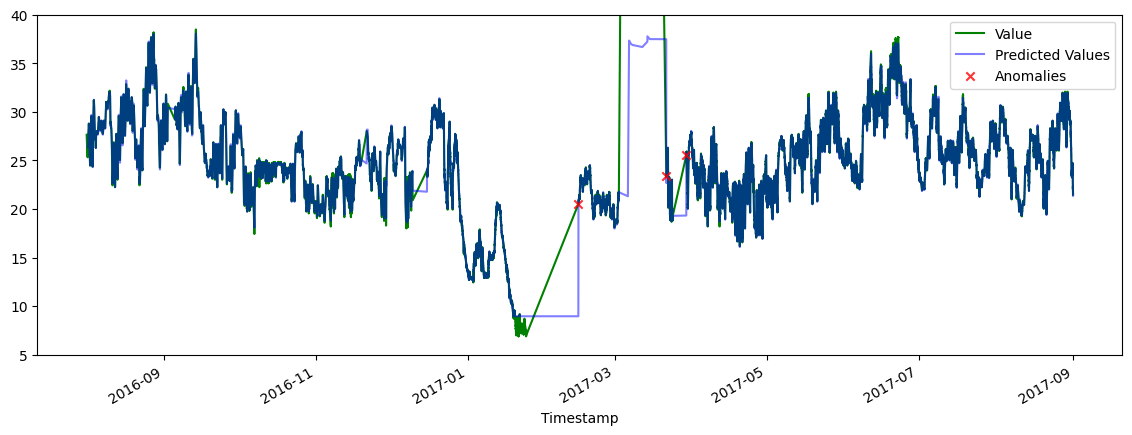

In [191]:
plot_anoms_tukey(df, preds, k=25)

In [192]:
# Combine actual values and predicted values
result = np.hstack([df['y'].values.reshape(-1,1), preds.values.reshape(-1,1)])
result

array([[26.67198563, 26.35137909],
       [27.05786133, 26.7239141 ],
       [27.25081825, 27.19034818],
       ...,
       [21.46577072, 21.58168767],
       [21.56214142, 21.33150627],
       [21.46577072, 21.58168767]])

Anomalous cluster label: -1
8 predicted anomalies


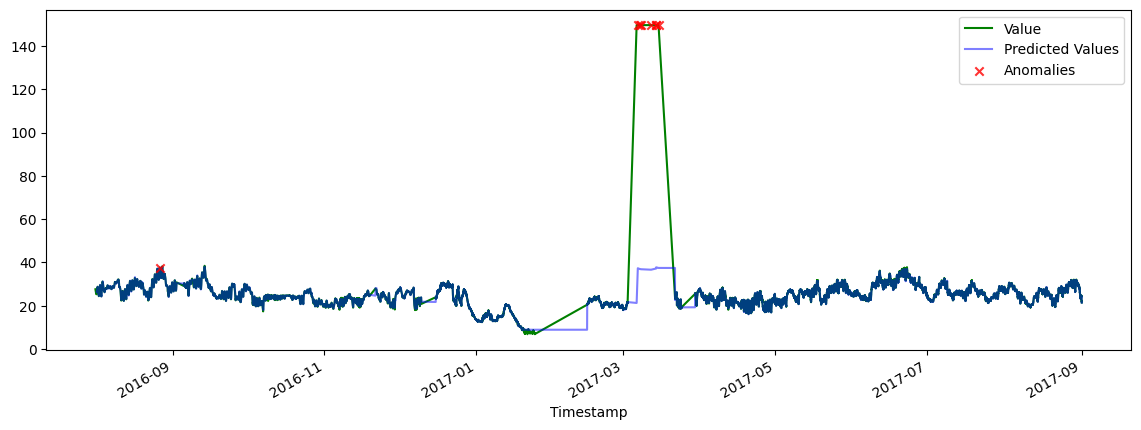

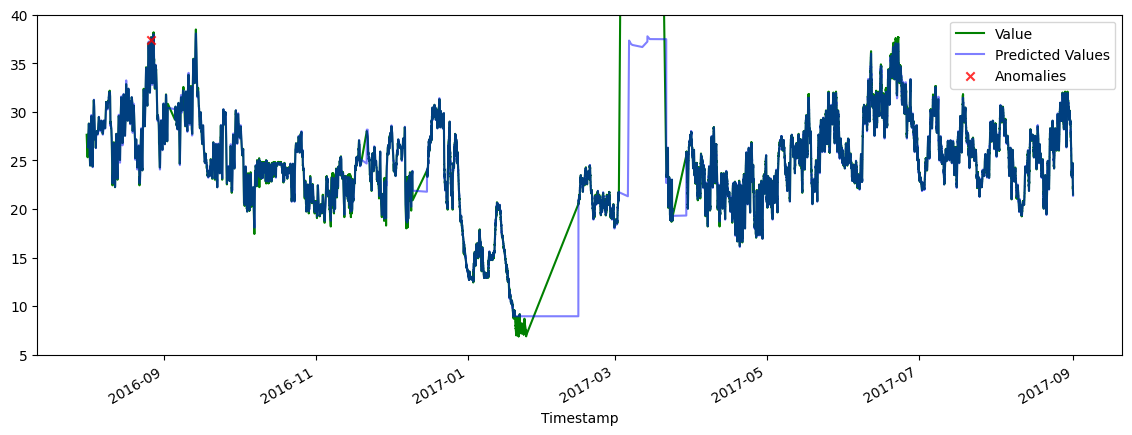

In [193]:
clusters = train_clusterer(result, result, IsolationForest(contamination=anoms_prop, random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 5
8 predicted anomalies


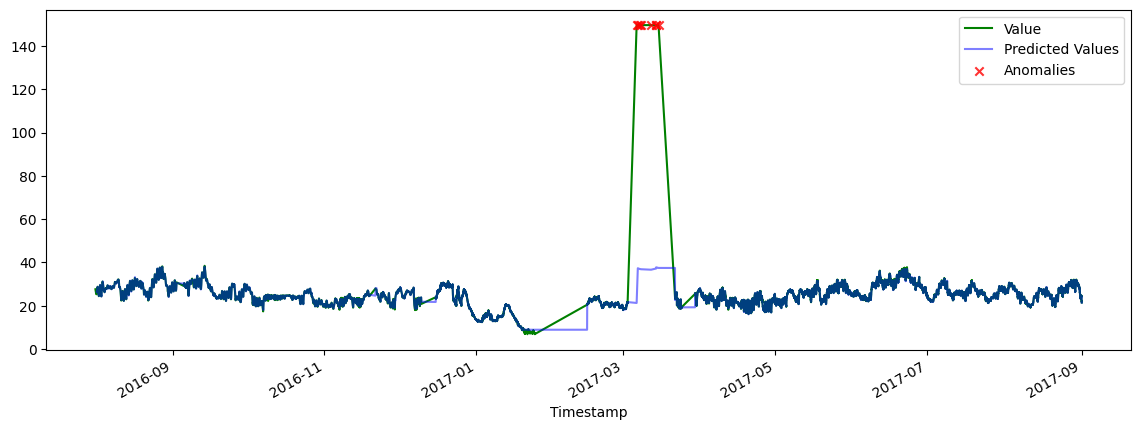

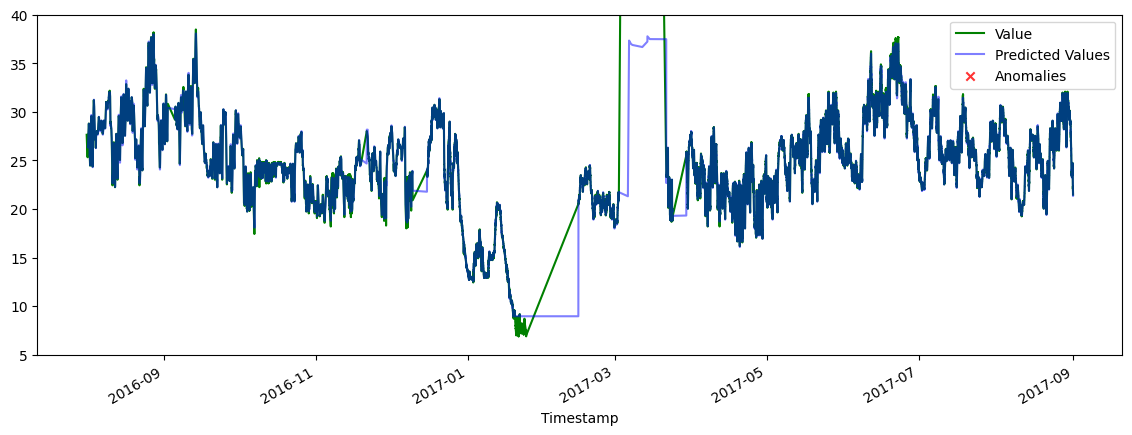

In [194]:
clusters = train_clusterer(result, result, KMeans(random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 2
7 predicted anomalies


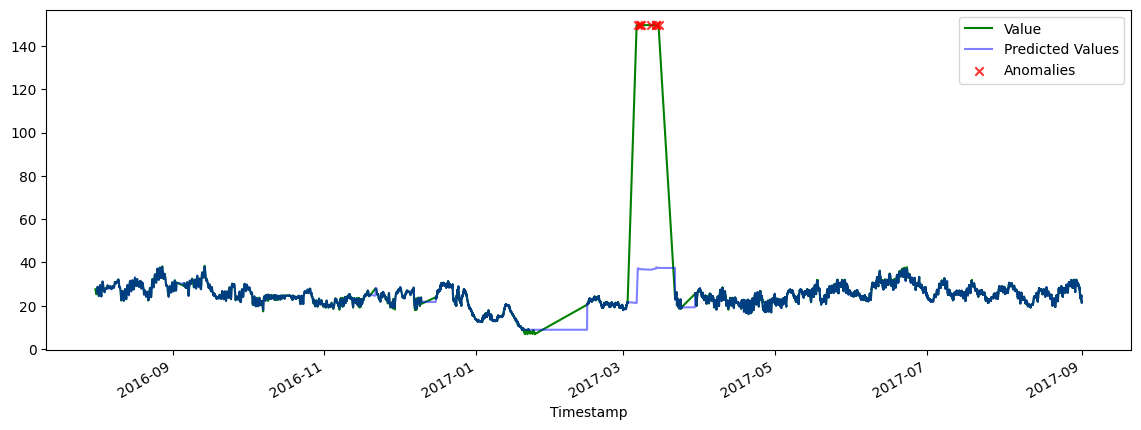

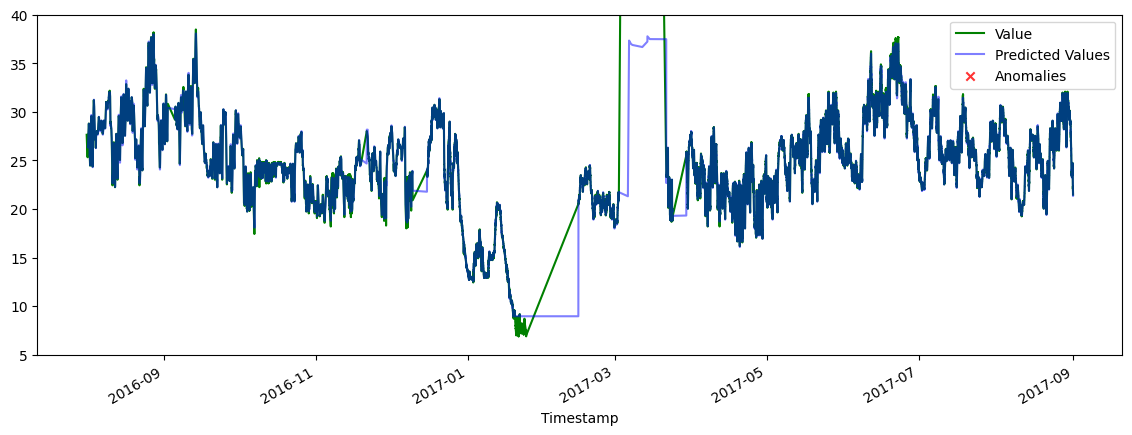

In [195]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(result)
plot_anoms_clustering(df, clusters, preds)

In [196]:
np.unique(clusters, return_counts=True)

(array([-1,  0,  1,  2], dtype=int64),
 array([   33, 61034,  1545,     7], dtype=int64))

In [197]:
# Missed one anomaly
df['y'][np.logical_and(clusters == -1, df['y'] > 140)]

Timestamp
2017-03-06 07:50:00+03:00    149.601822
Name: y, dtype: float64

40 predicted anomalies


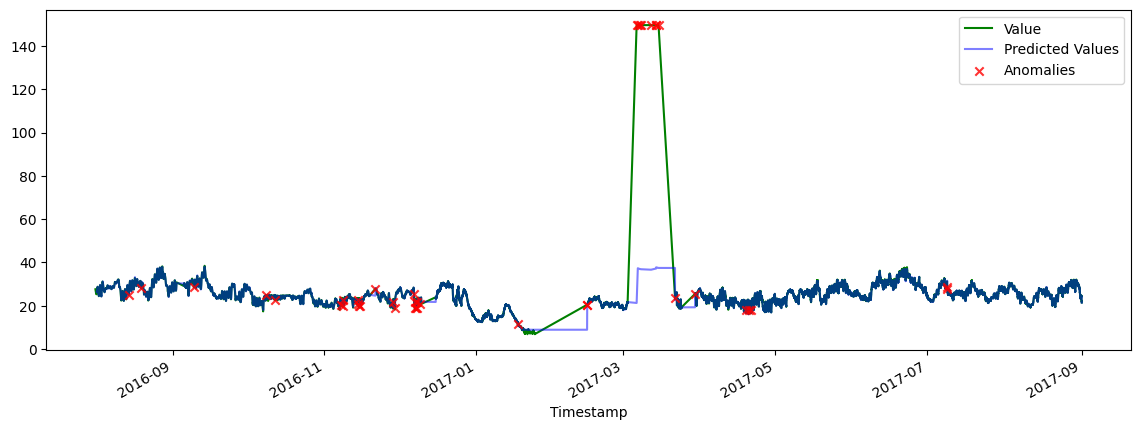

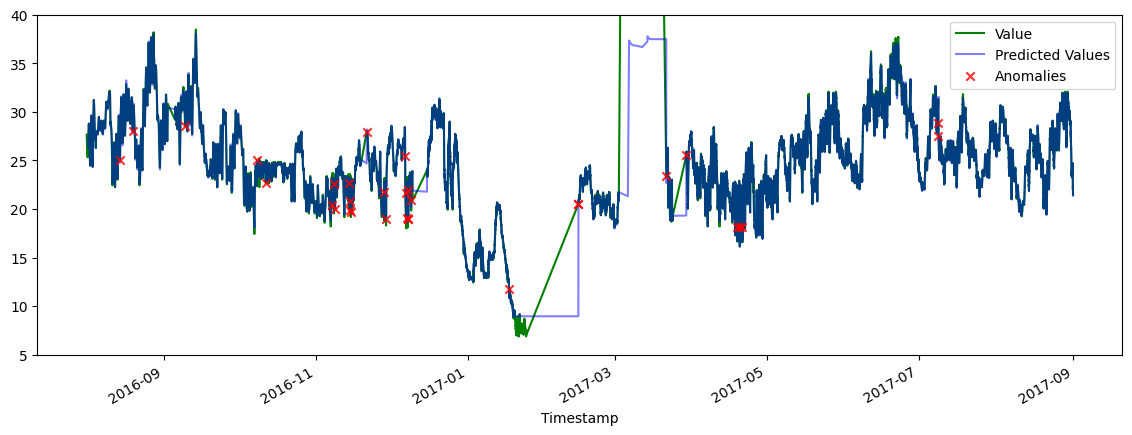

In [198]:
# Suppose we plot all clusters of size <50
plot_anoms_clustering(df, clusters, preds, clusters_to_plot=[-1,2])

#### K-Nearest Neighbors Regressor

In [199]:
preds = train_regressor(df, Xtrain, ytrain, KNeighborsRegressor())

28 predicted anomalies


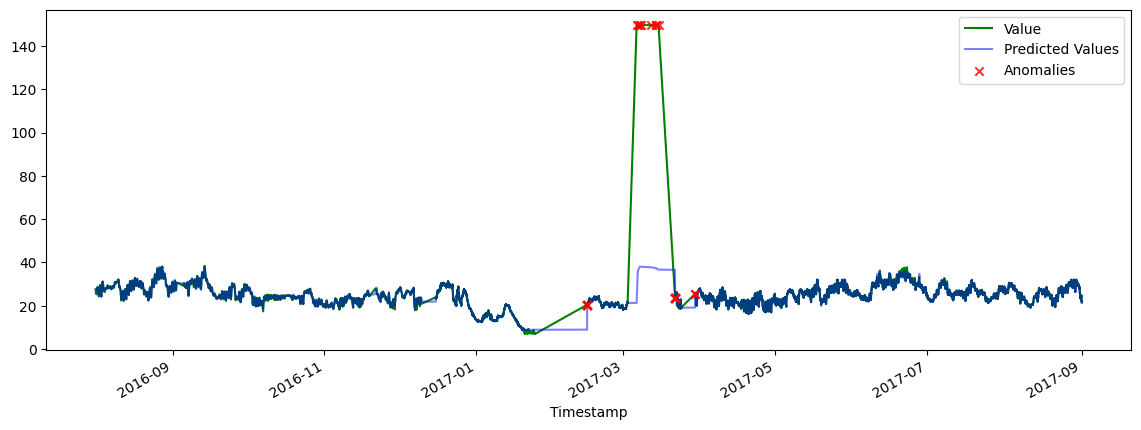

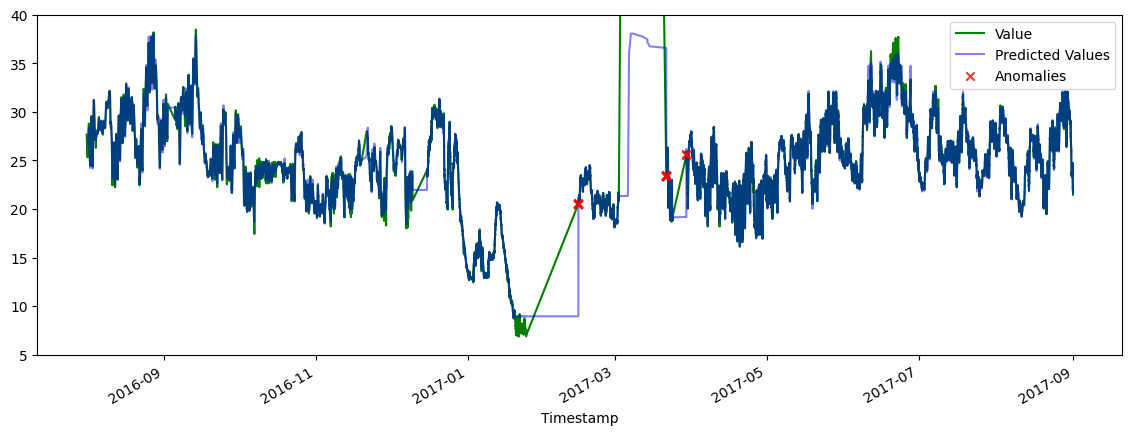

In [200]:
plot_anoms_zscores(df, preds)

26 predicted anomalies


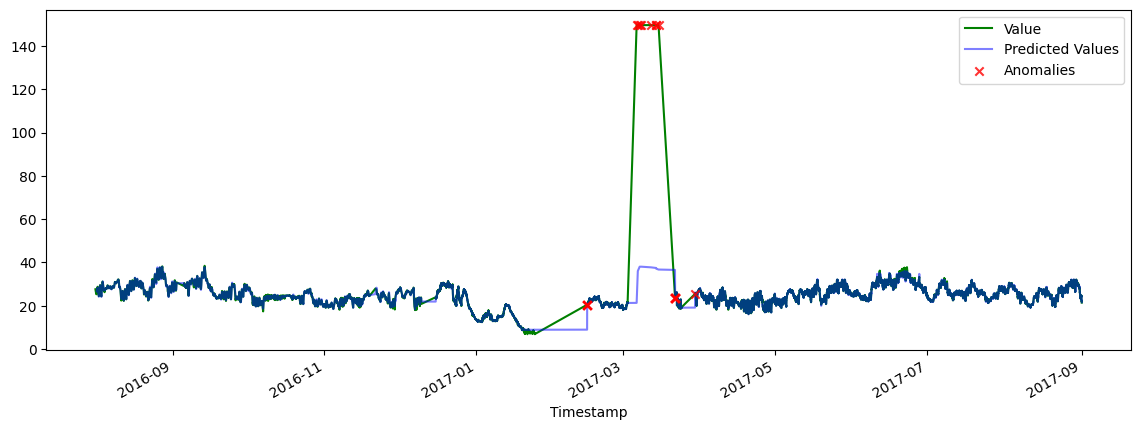

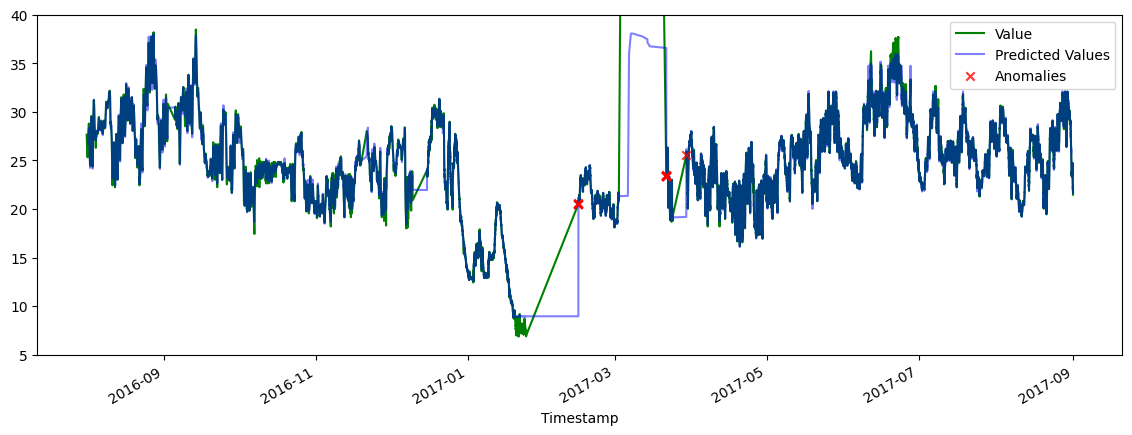

In [201]:
plot_anoms_tukey(df, preds, 25)

In [202]:
# Combine actual values and predicted values
result = np.hstack([df['y'].values.reshape(-1,1), preds.values.reshape(-1,1)])
result

array([[26.67198563, 26.69128456],
       [27.05786133, 27.09649963],
       [27.25081825, 27.05786858],
       ...,
       [21.46577072, 21.75484505],
       [21.56214142, 21.67776107],
       [21.46577072, 21.65849113]])

Anomalous cluster label: -1
5 predicted anomalies


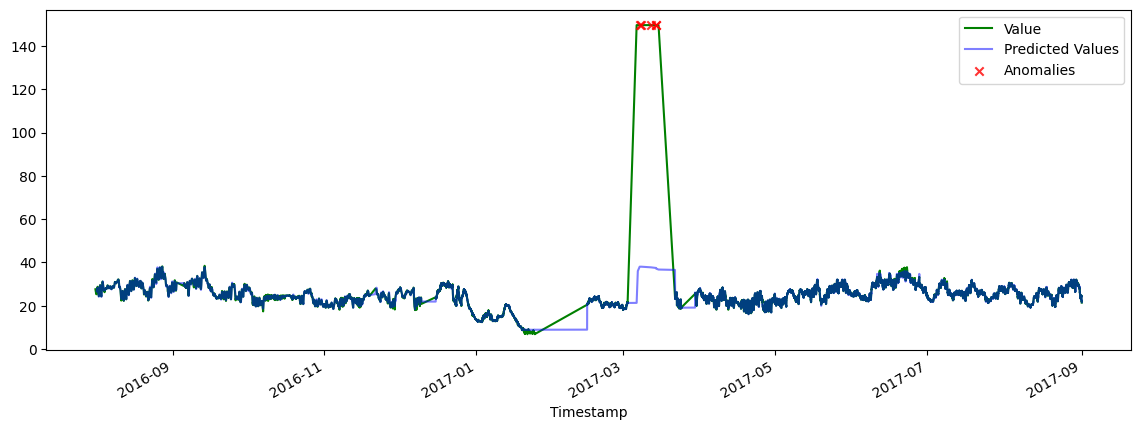

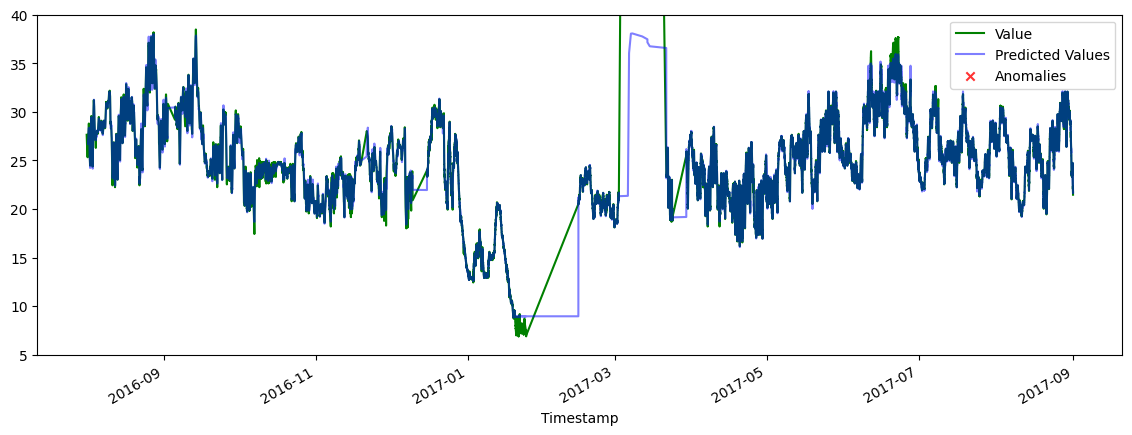

In [203]:
clusters = train_clusterer(result, result, IsolationForest(contamination=anoms_prop, random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 6
8 predicted anomalies


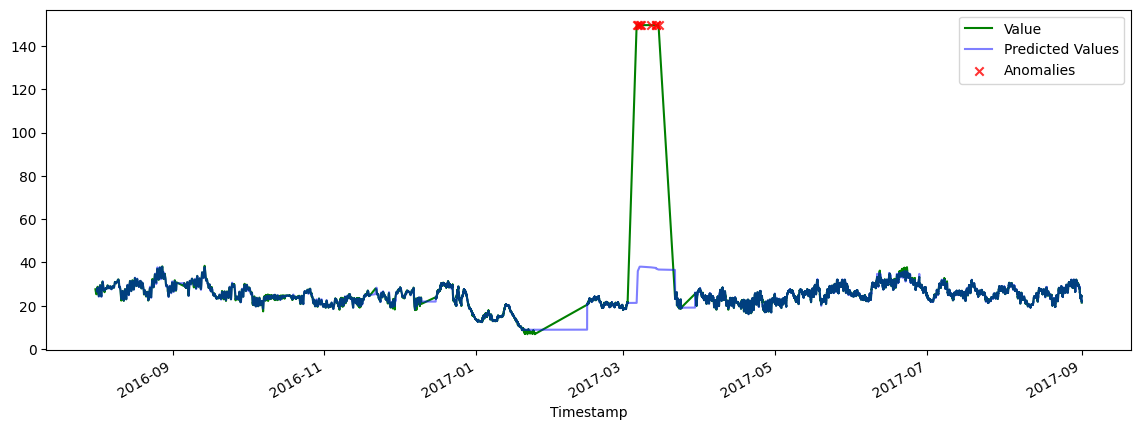

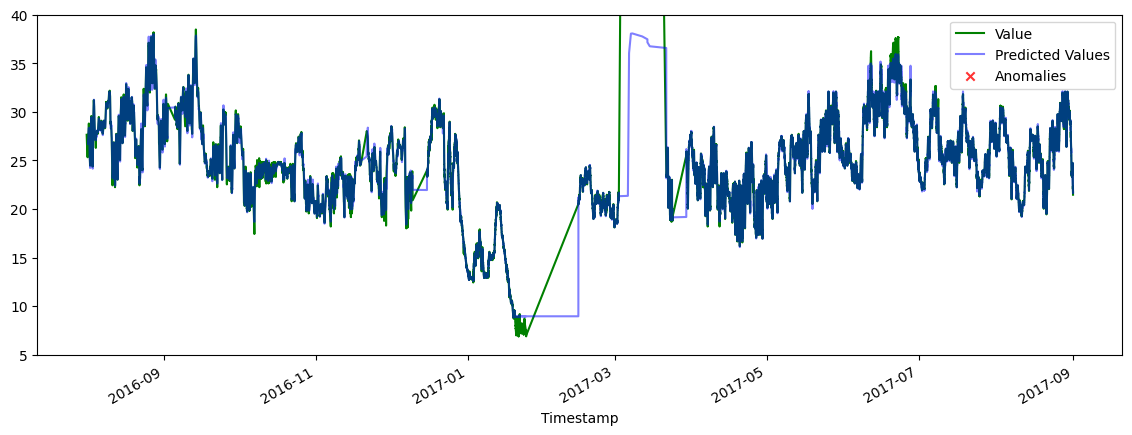

In [204]:
clusters = train_clusterer(result, result, KMeans(random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: -1
47 predicted anomalies


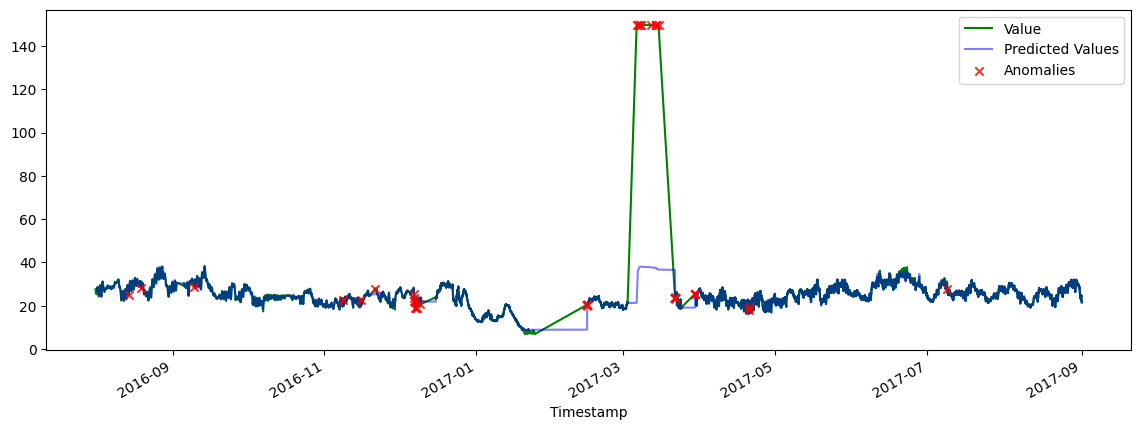

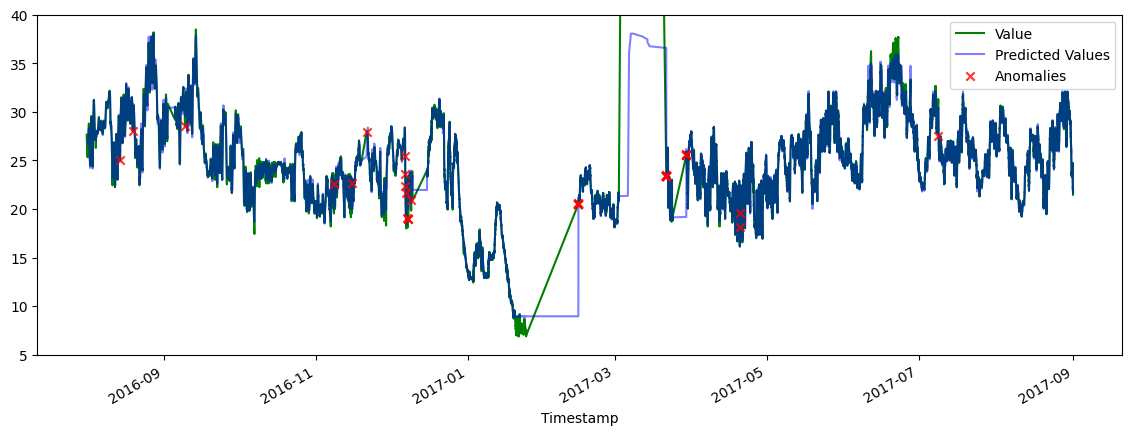

In [205]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(result)
plot_anoms_clustering(df, clusters, preds)

### Deep Learning Regressors

#### Simple Recurent Neural Network (RNN)

In [133]:
window = 10
df = prepare_input_data(data, window=window)

In [134]:
train, test = train_test_split(df, test_size=0.8, shuffle=False)
train, valid = train_test_split(train, test_size=0.2, shuffle=True, random_state=random_state)

Xtrain = train.drop('y', axis=1).values.reshape(-1, window, 1)
ytrain = train['y'].values.reshape(-1, 1)
Xvalid = valid.drop('y', axis=1).values.reshape(-1, window, 1)
yvalid = valid['y'].values.reshape(-1, 1)

In [135]:
X = df.drop('y', axis=1).values.reshape(-1, window, 1)
y = df['y']

In [136]:
model = Sequential()
model.add(SimpleRNN(units=32,
                    return_sequences=False,
                    input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

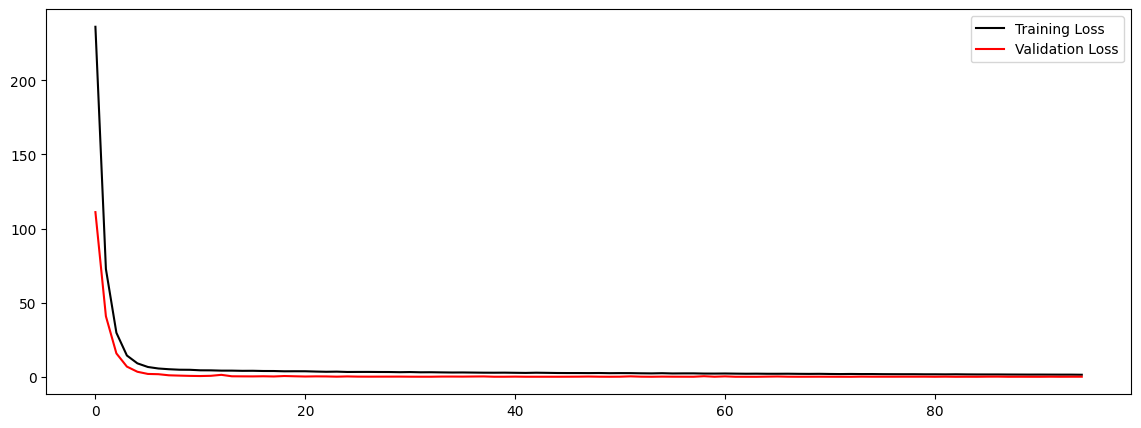

In [137]:
history = train_dl_model(model, Xtrain, ytrain, Xvalid, yvalid)
plot_dl_losses(history)

In [138]:
preds = model.predict(X)
preds = pd.Series(preds.reshape(1,-1)[0], index=df.index, name='Predicted y')

1957/1957 [==============================] - 4s 2ms/step


In [139]:
model.evaluate(X, y)

1957/1957 [==============================] - 4s 2ms/step - loss: 1.9113 - root_mean_squared_error: 1.3825 - mean_absolute_error: 0.2624


[1.9113260507583618, 1.3825072050094604, 0.26236870884895325]

23 predicted anomalies


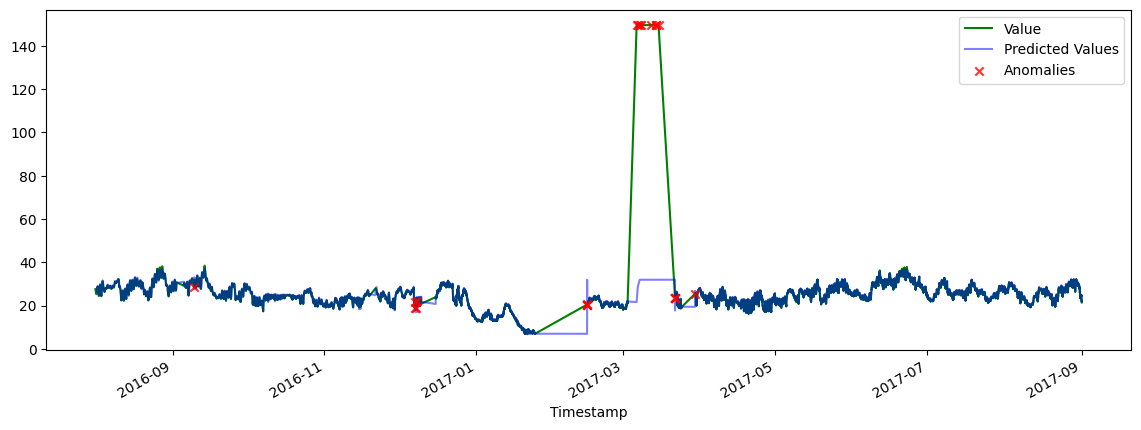

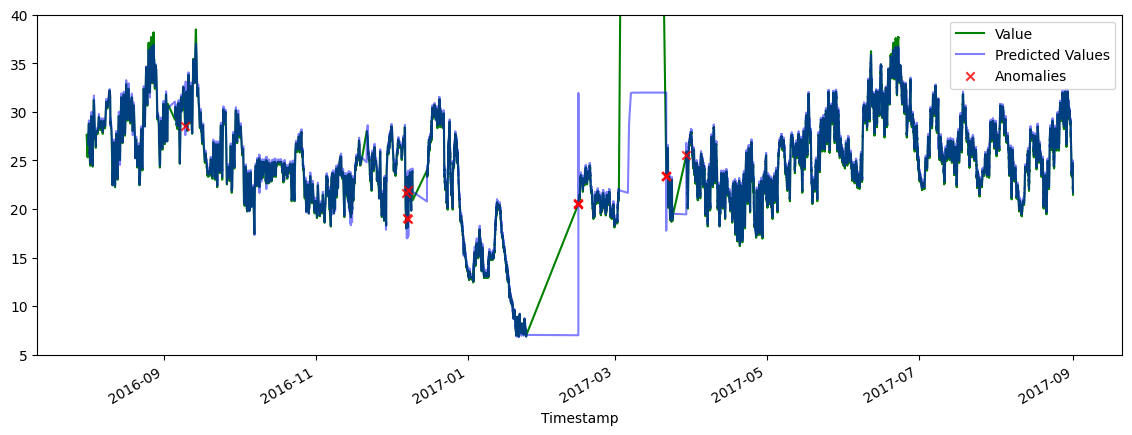

In [140]:
plot_anoms_zscores(df, preds)

36 predicted anomalies


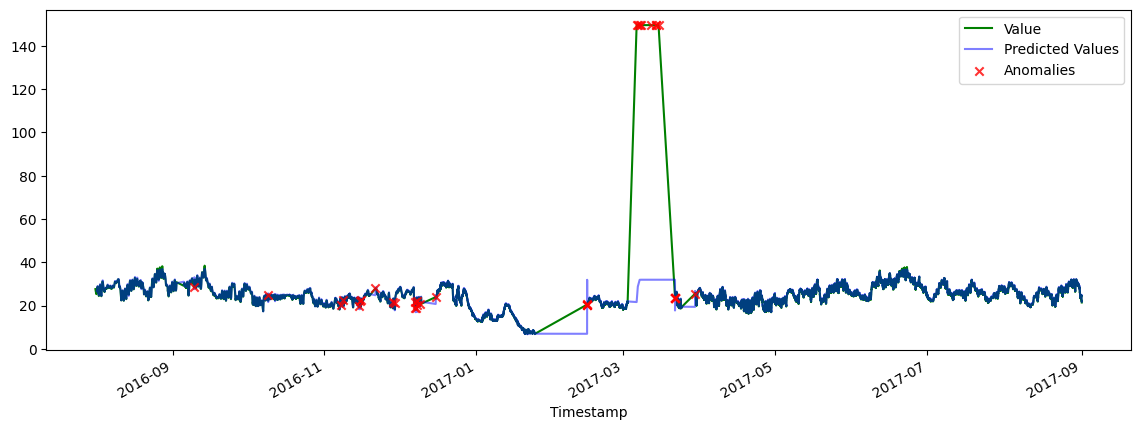

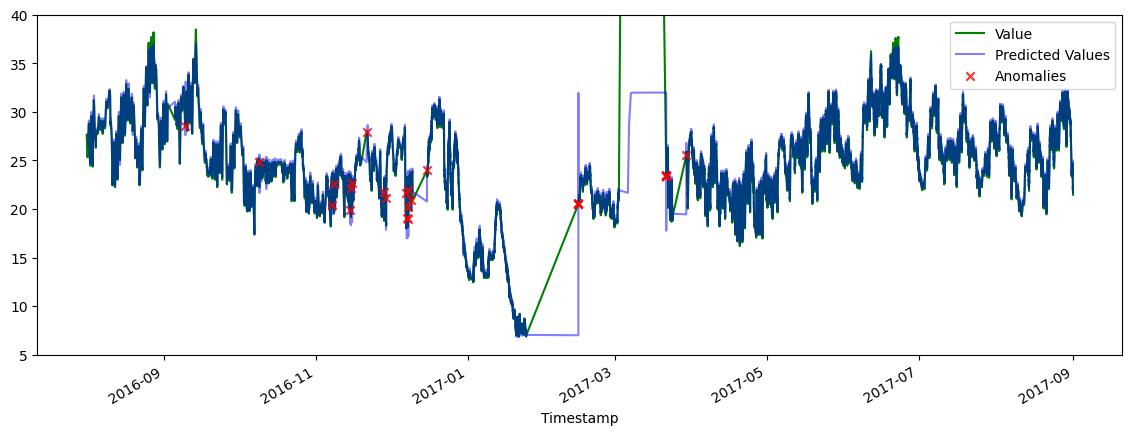

In [141]:
plot_anoms_tukey(df, preds, k=25)

In [142]:
# Combine actual values and predicted values
result = np.hstack([df['y'].values.reshape(-1,1), preds.values.reshape(-1,1)])
result

array([[26.67198563, 26.65388489],
       [27.05786133, 26.99322128],
       [27.25081825, 27.35568237],
       ...,
       [21.46577072, 21.75432396],
       [21.56214142, 21.67162323],
       [21.46577072, 21.83849335]])

Anomalous cluster label: -1
8 predicted anomalies


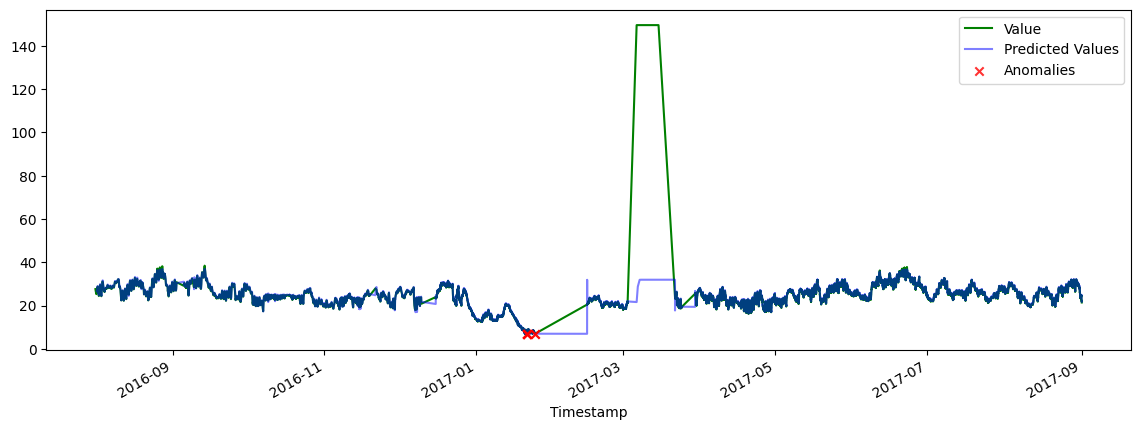

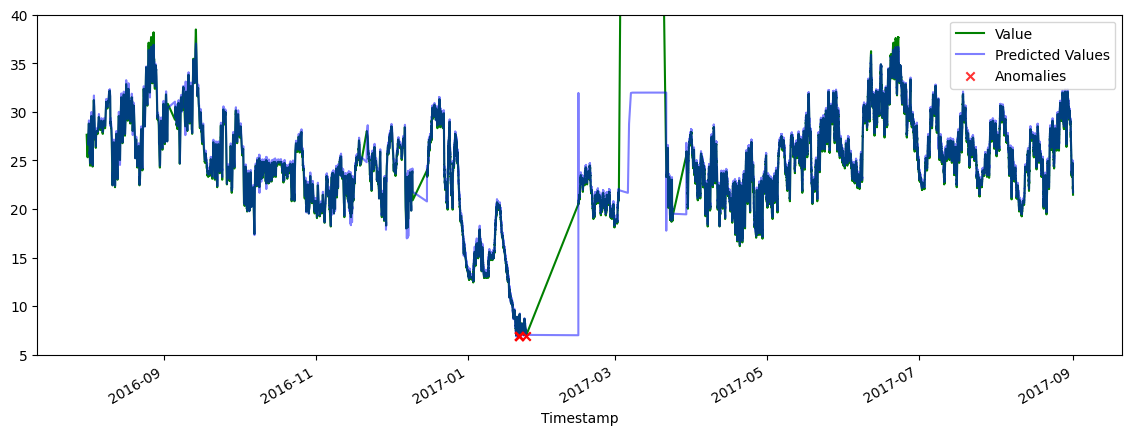

In [143]:
clusters = train_clusterer(result, result, IsolationForest(contamination=anoms_prop, random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 6
8 predicted anomalies


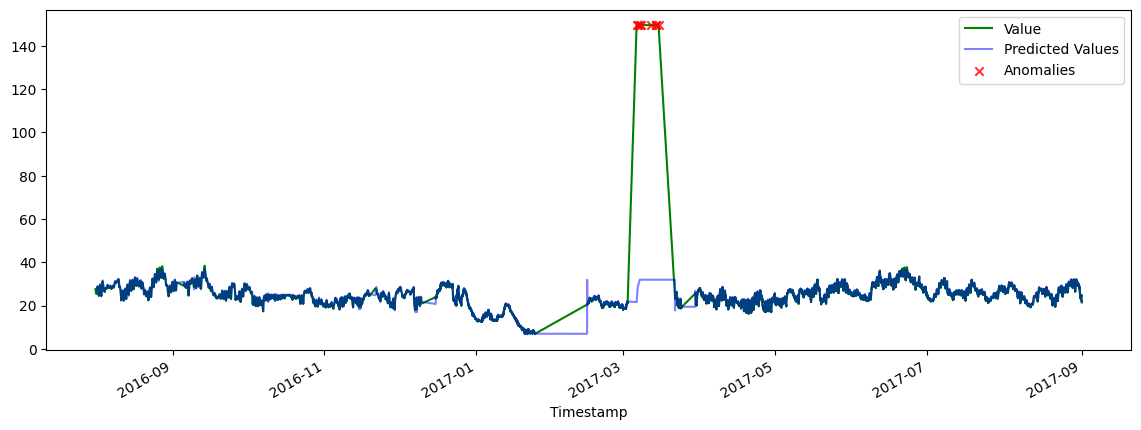

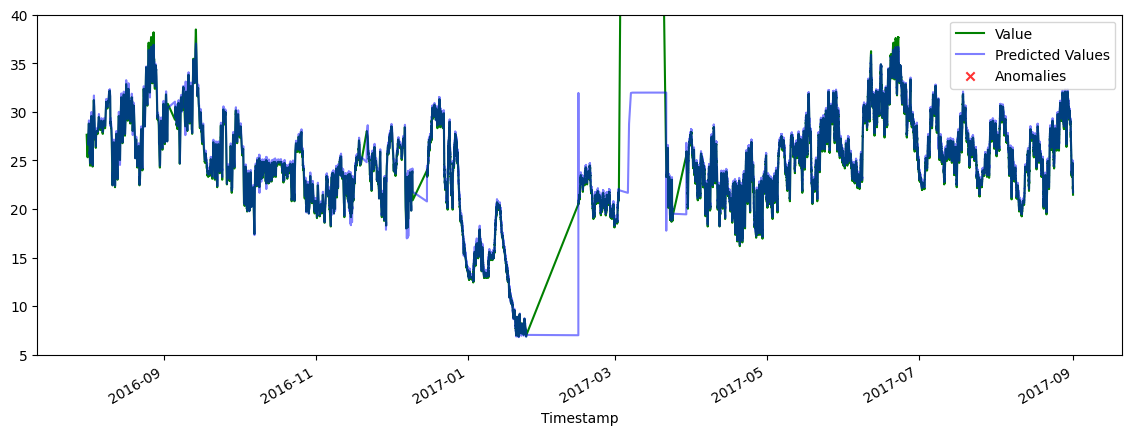

In [144]:
clusters = train_clusterer(result, result, KMeans(random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 2
6 predicted anomalies


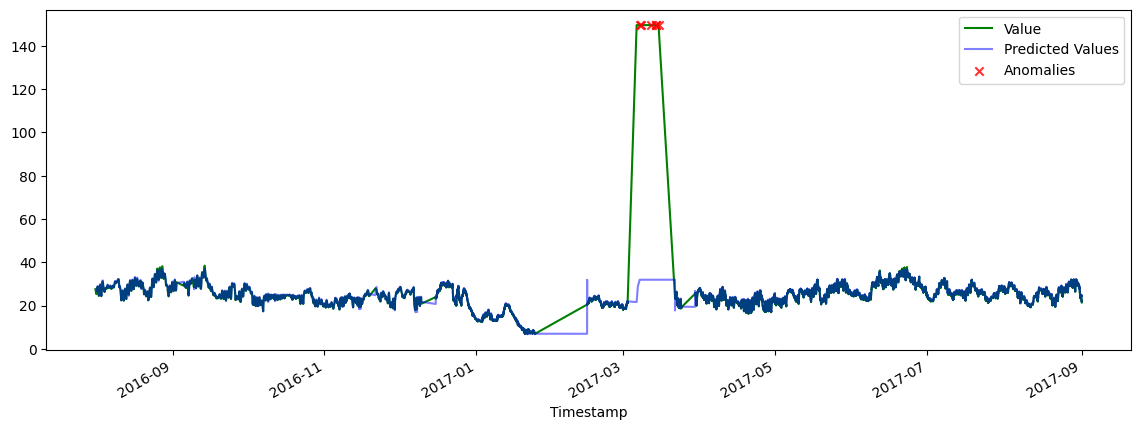

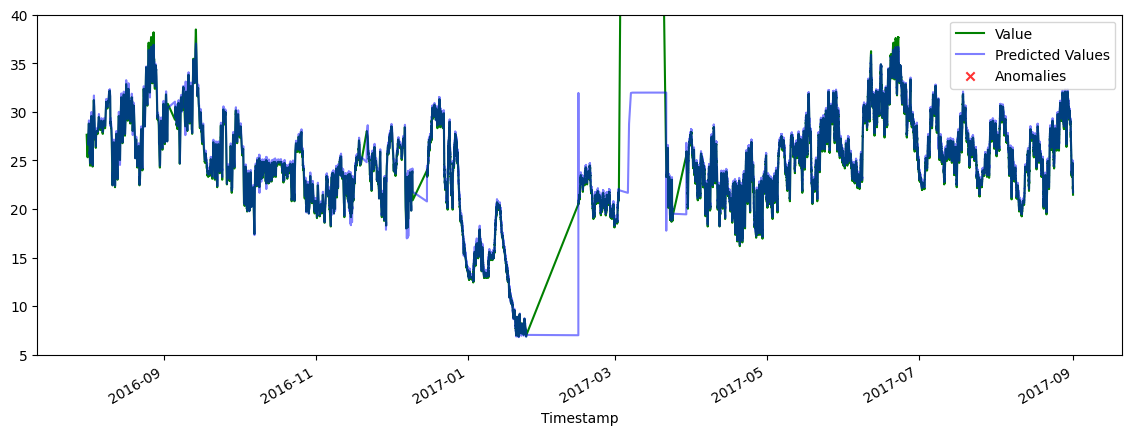

In [145]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(result)
plot_anoms_clustering(df, clusters, preds)

In [146]:
np.unique(clusters, return_counts=True)

(array([-1,  0,  1,  2], dtype=int64),
 array([   44, 61024,  1545,     6], dtype=int64))

In [148]:
# Here are the rest of the anomalies
df['y'][np.logical_and(clusters == -1, df['y'] > 140)]

Timestamp
2017-03-06 07:50:00+03:00    149.601822
2017-03-06 19:10:00+03:00    149.601822
Name: y, dtype: float64

50 predicted anomalies


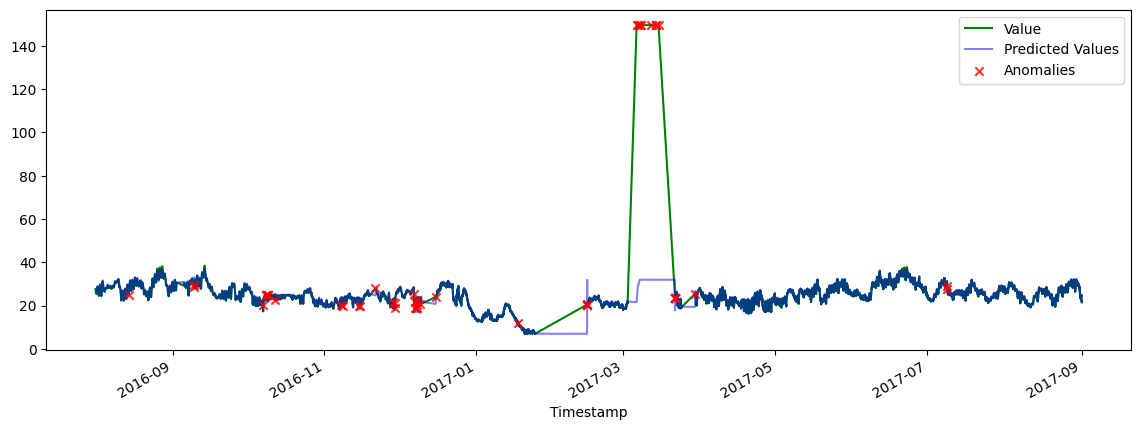

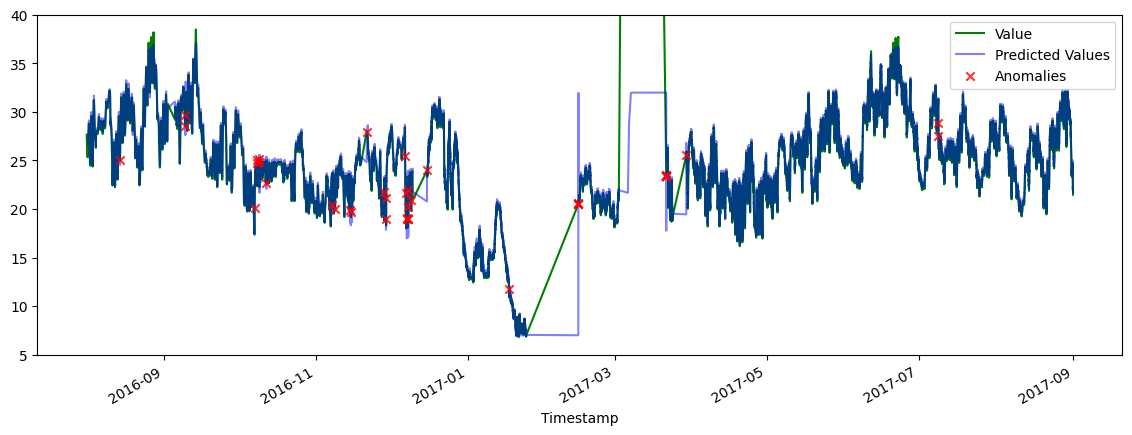

In [149]:
# Suppose we plot all clusters of size <50
plot_anoms_clustering(df, clusters, preds, clusters_to_plot=[-1,2])

#### Long-Term Short-Term Memory (LSTM) Network

In [150]:
model = keras.Sequential()
model.add(LSTM(units=32,
               return_sequences=False,
               input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

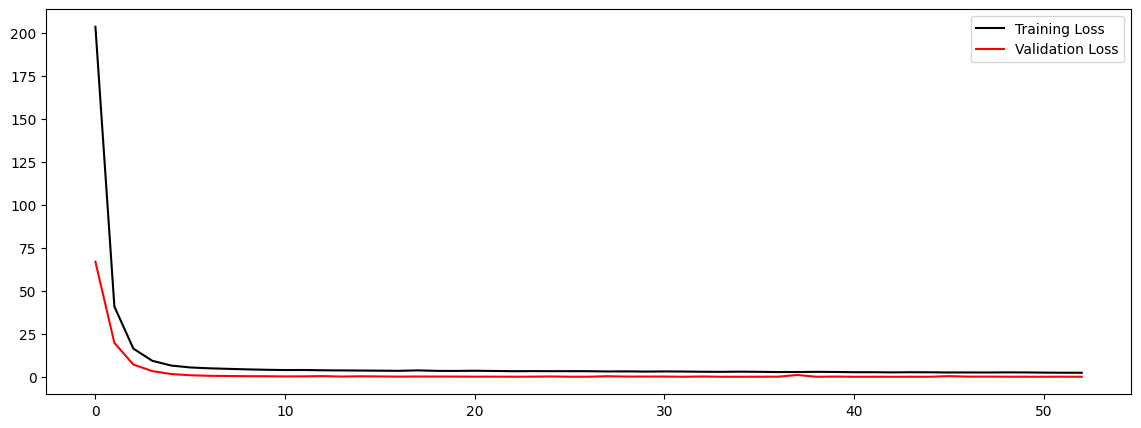

In [151]:
history = train_dl_model(model, Xtrain, ytrain, Xvalid, yvalid)
plot_dl_losses(history)

In [152]:
preds = model.predict(X)
preds = pd.Series(preds.reshape(1,-1)[0], index=df.index, name='Predicted y')

1957/1957 [==============================] - 3s 2ms/step


In [153]:
model.evaluate(X, y)

1957/1957 [==============================] - 3s 2ms/step - loss: 1.8853 - root_mean_squared_error: 1.3731 - mean_absolute_error: 0.1682


[1.8853400945663452, 1.3730769157409668, 0.1682274341583252]

24 predicted anomalies


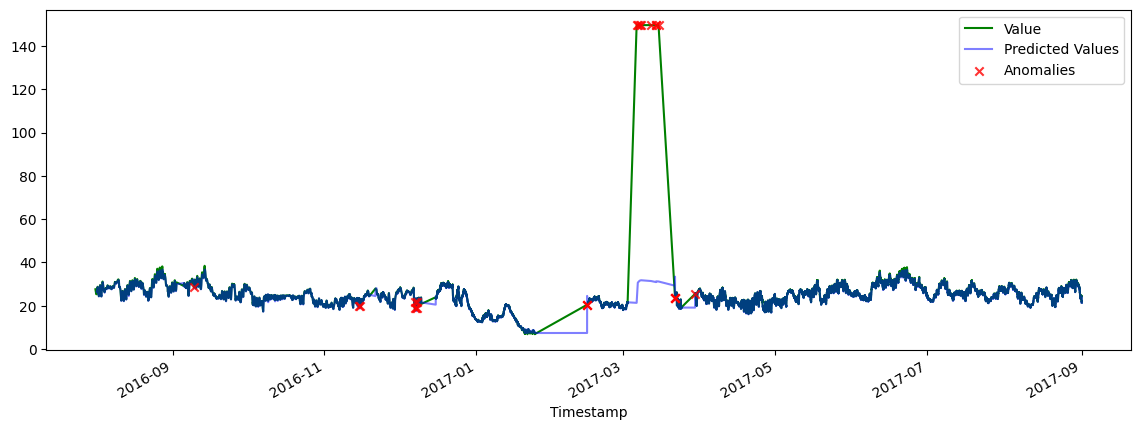

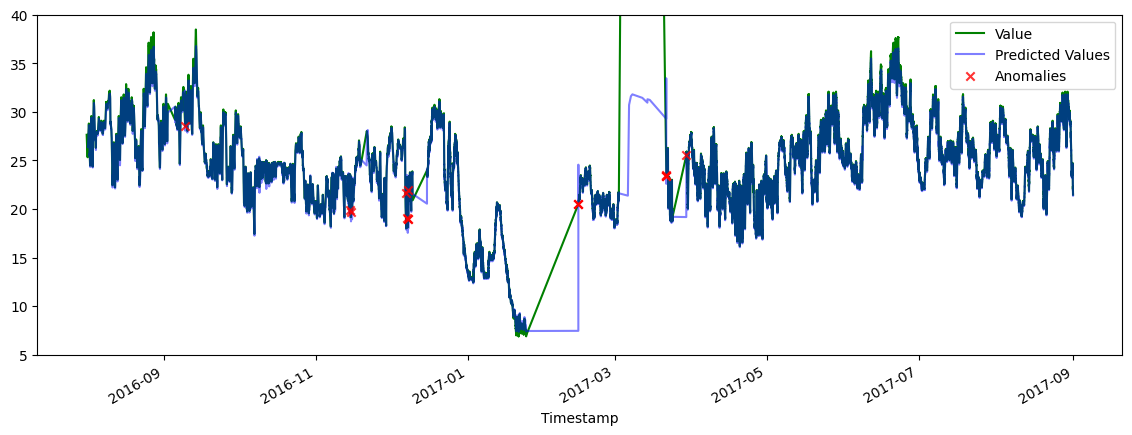

In [154]:
plot_anoms_zscores(df, preds)

30 predicted anomalies


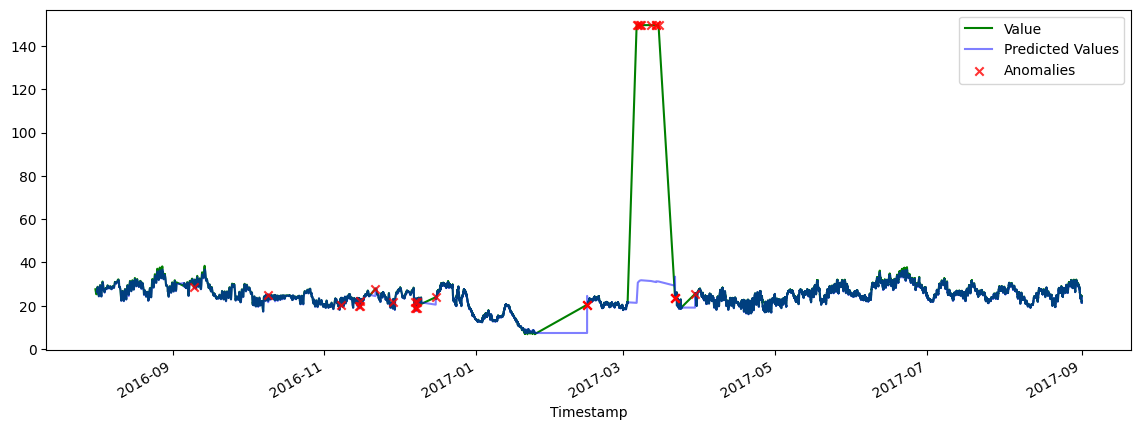

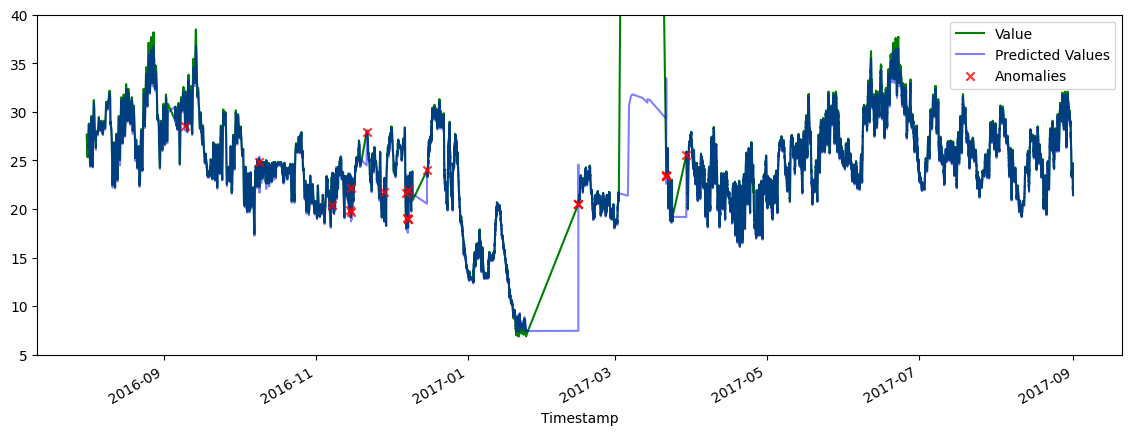

In [155]:
plot_anoms_tukey(df, preds, k=25)

In [156]:
# Combine actual values and predicted values
result = np.hstack([df['y'].values.reshape(-1,1), preds.values.reshape(-1,1)])
result

array([[26.67198563, 26.36977005],
       [27.05786133, 26.62929535],
       [27.25081825, 26.97561073],
       ...,
       [21.46577072, 21.46605873],
       [21.56214142, 21.35012627],
       [21.46577072, 21.49847221]])

Anomalous cluster label: 1
62619 predicted anomalies


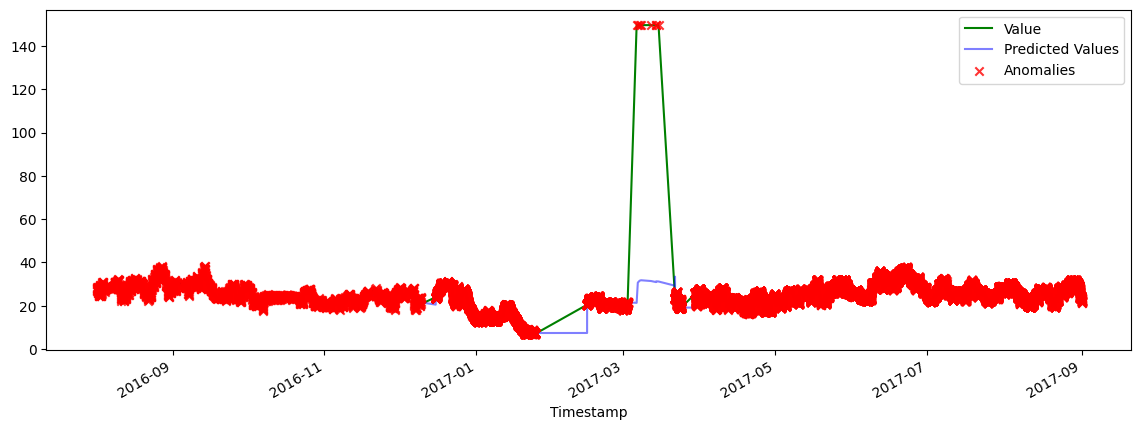

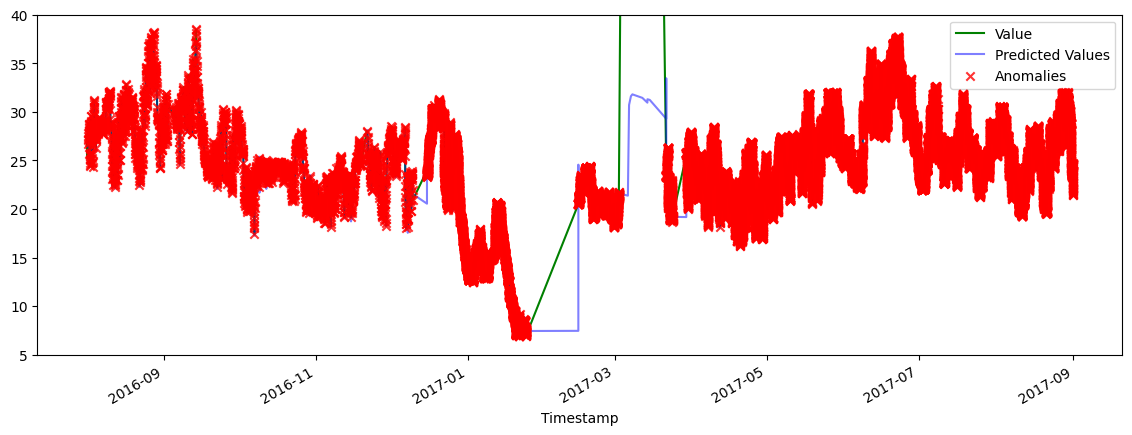

In [157]:
clusters = train_clusterer(result, result, IsolationForest(contamination=anoms_prop, random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 5
8 predicted anomalies


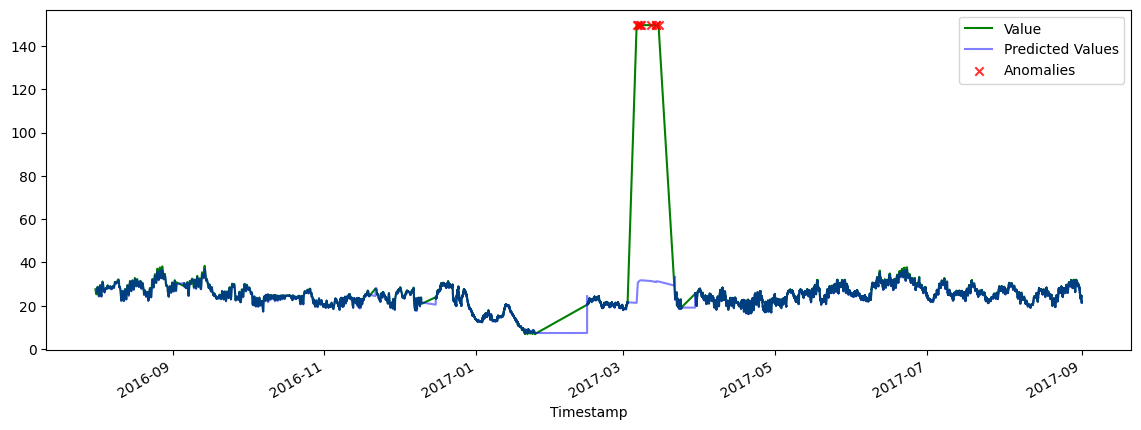

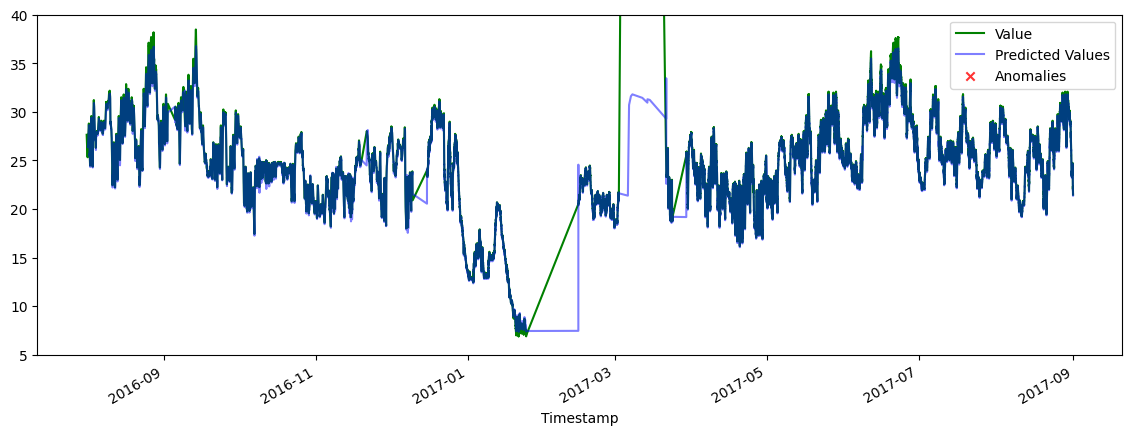

In [158]:
clusters = train_clusterer(result, result, KMeans(random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 1
5 predicted anomalies


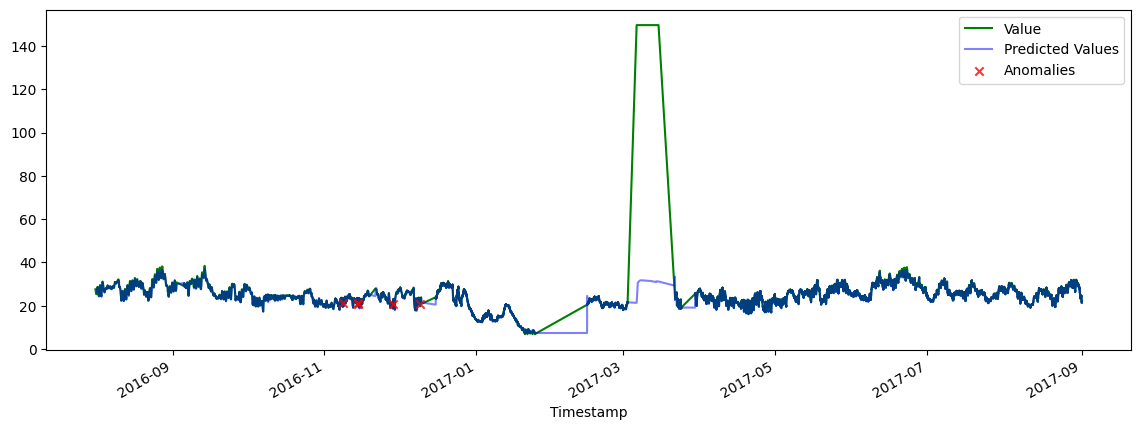

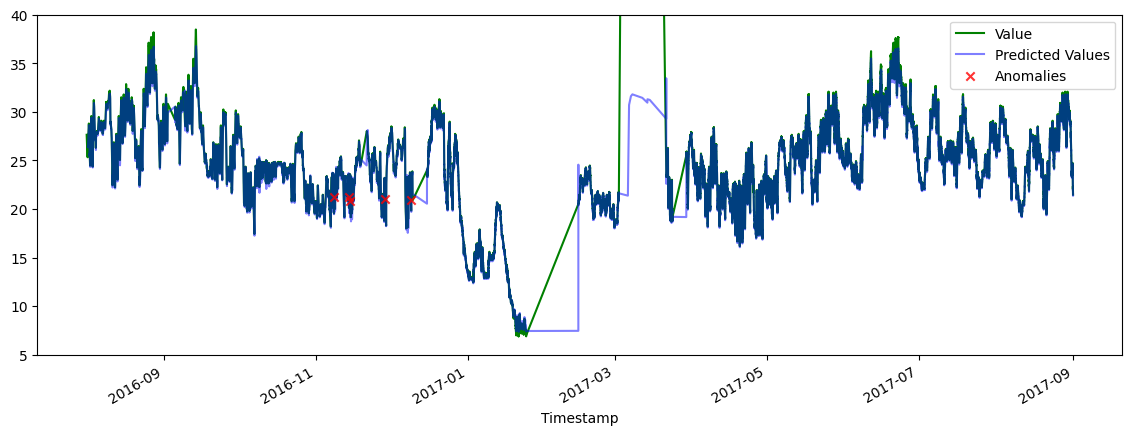

In [159]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(result)
plot_anoms_clustering(df, clusters, preds)

In [160]:
np.unique(clusters, return_counts=True)

(array([-1,  0,  1,  2,  3], dtype=int64),
 array([   46, 61016,     5,  1545,     7], dtype=int64))

In [161]:
# Missed the anomalous cluster
df['y'][clusters == 3]

Timestamp
2017-03-06 19:10:00+03:00    149.601822
2017-03-07 13:00:00+03:00    149.601822
2017-03-08 03:10:00+03:00    149.601822
2017-03-12 03:00:00+03:00    149.601822
2017-03-14 03:50:00+03:00    149.601822
2017-03-14 04:00:00+03:00    149.601822
2017-03-15 02:45:00+03:00    149.601822
Name: y, dtype: float64

12 predicted anomalies


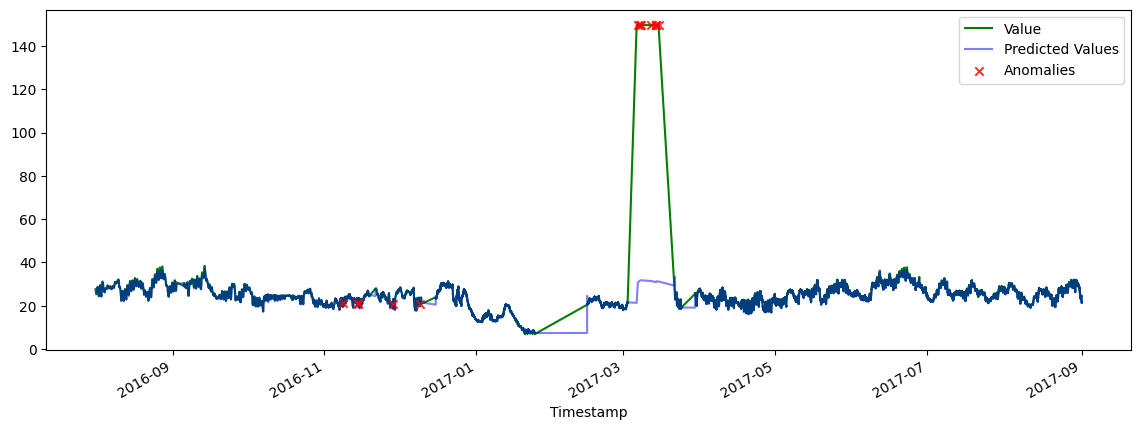

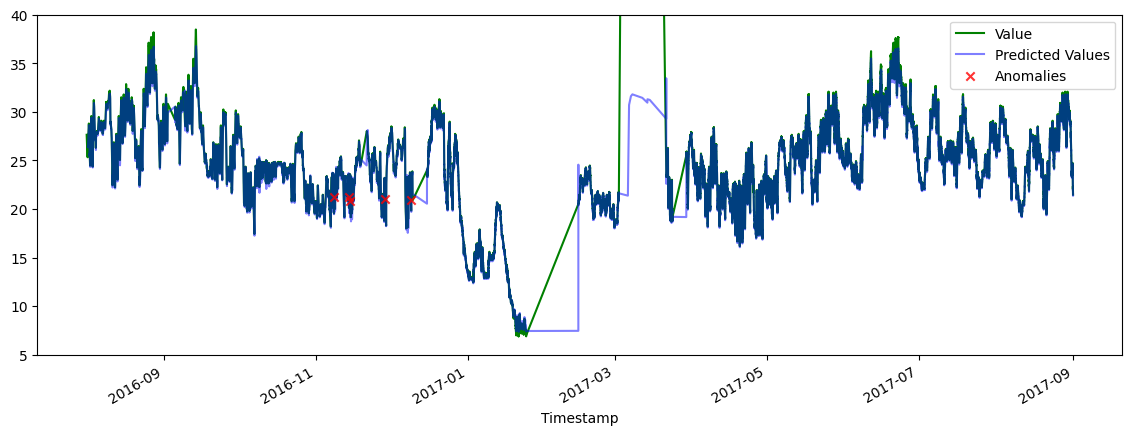

In [163]:
# Suppose we plot all clusters of size <10
plot_anoms_clustering(df, clusters, preds, clusters_to_plot=[1,3])

#### Gated Recurrent Unit (GRU) Network

In [164]:
model = keras.Sequential()
model.add(GRU(units=32, 
              return_sequences=False,
              input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

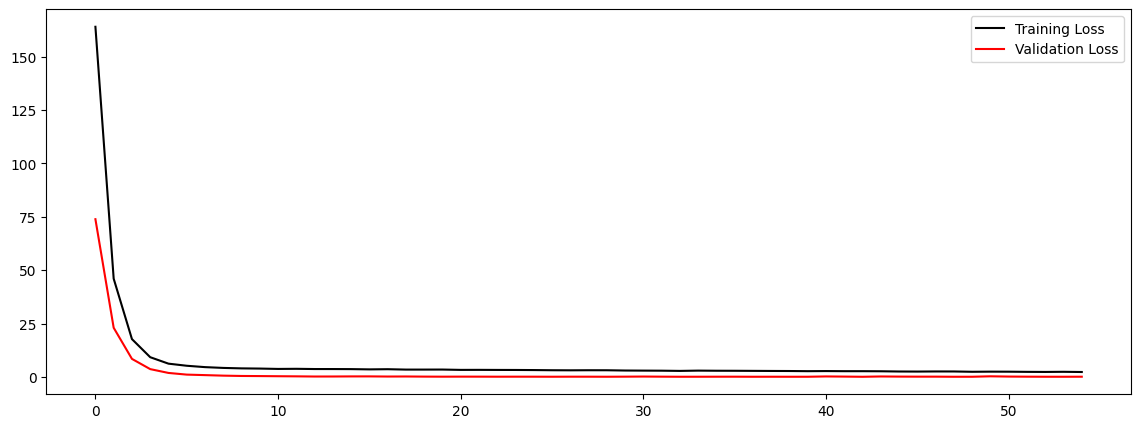

In [165]:
history = train_dl_model(model, Xtrain, ytrain, Xvalid, yvalid)
plot_dl_losses(history)

In [166]:
preds = model.predict(X)
preds = pd.Series(preds.reshape(1,-1)[0], index=df.index, name='Predicted y')

1957/1957 [==============================] - 3s 1ms/step


In [167]:
model.evaluate(X, y)

1957/1957 [==============================] - 3s 2ms/step - loss: 1.8737 - root_mean_squared_error: 1.3688 - mean_absolute_error: 0.2524


[1.8737322092056274, 1.36884343624115, 0.25235843658447266]

22 predicted anomalies


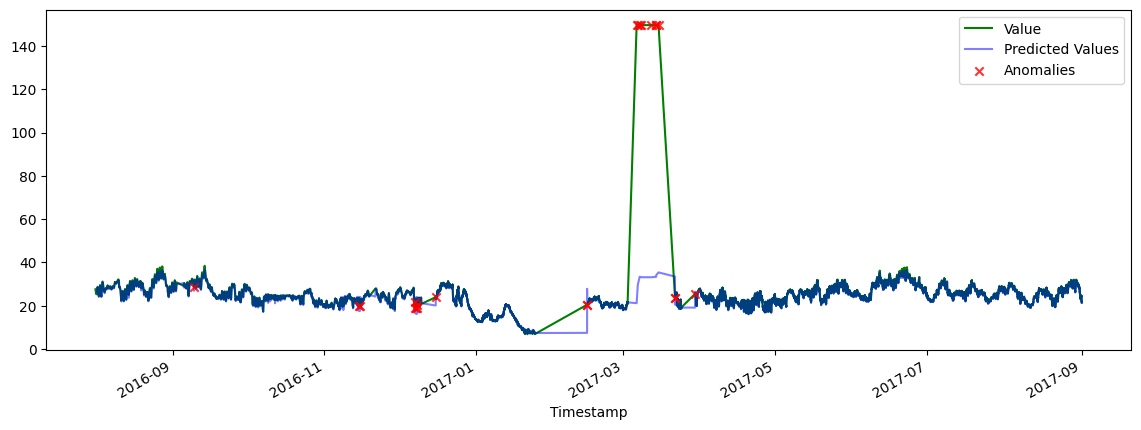

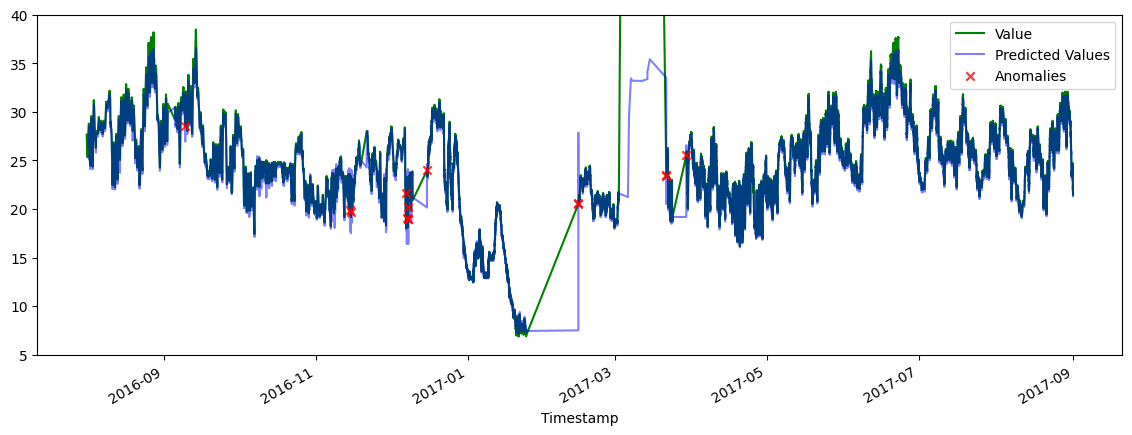

In [168]:
plot_anoms_zscores(df, preds)

15 predicted anomalies


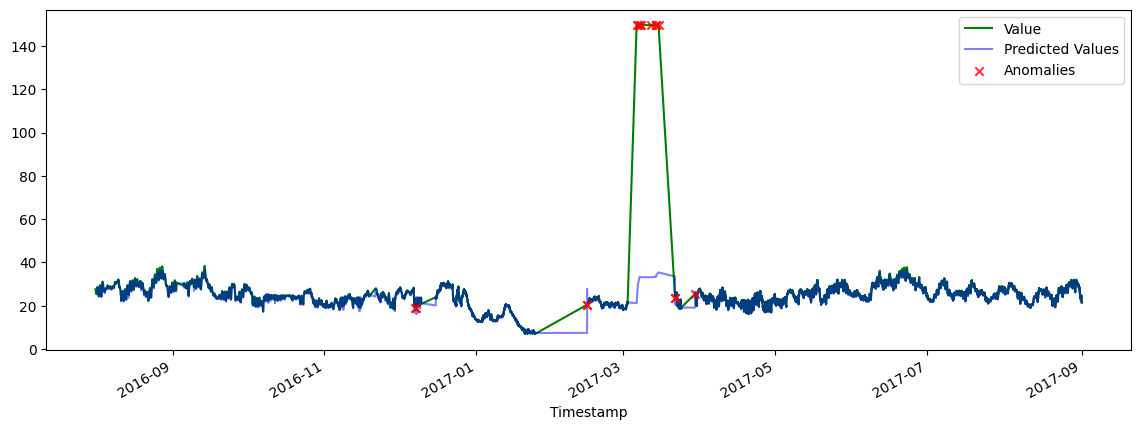

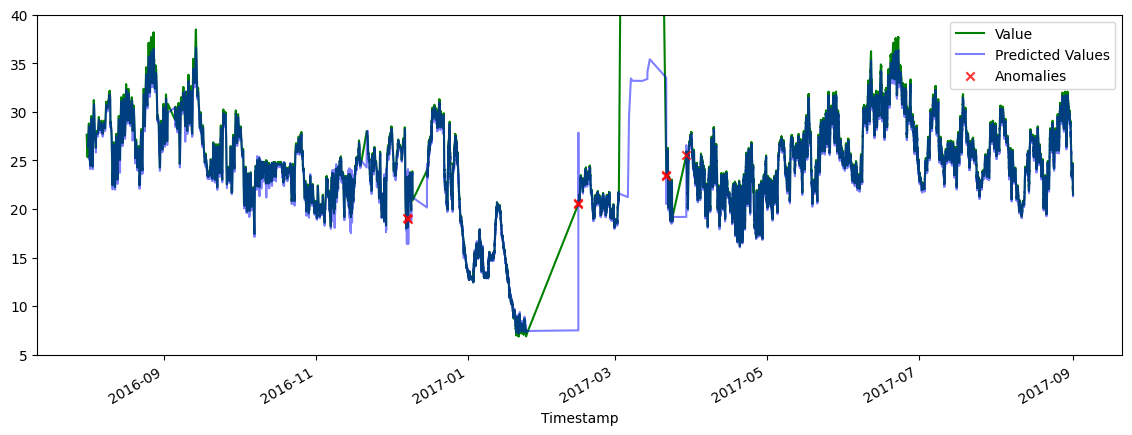

In [169]:
plot_anoms_tukey(df, preds, k=25)

In [170]:
# Combine actual values and predicted values
result = np.hstack([df['y'].values.reshape(-1,1), preds.values.reshape(-1,1)])
result

array([[26.67198563, 26.36388206],
       [27.05786133, 26.56954765],
       [27.25081825, 26.90165901],
       ...,
       [21.46577072, 21.30991936],
       [21.56214142, 21.28575706],
       [21.46577072, 21.41044044]])

Anomalous cluster label: 1
62619 predicted anomalies


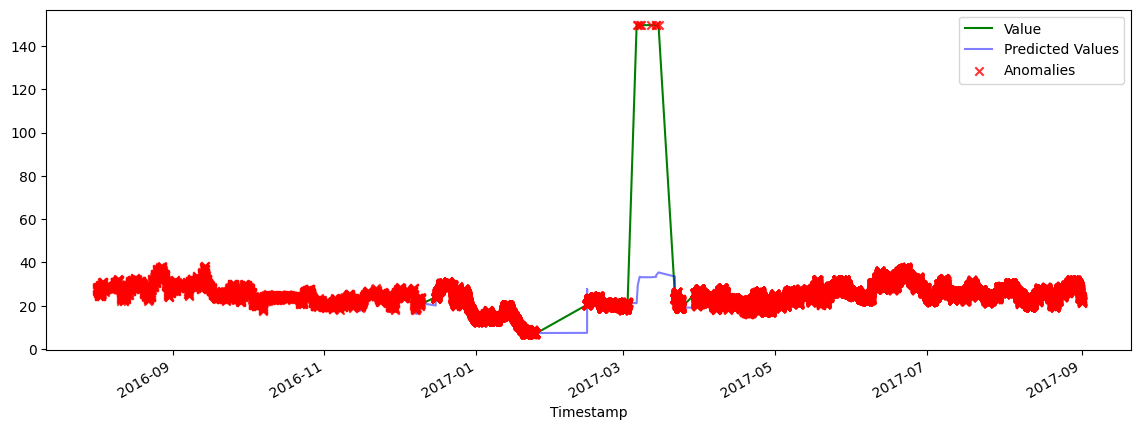

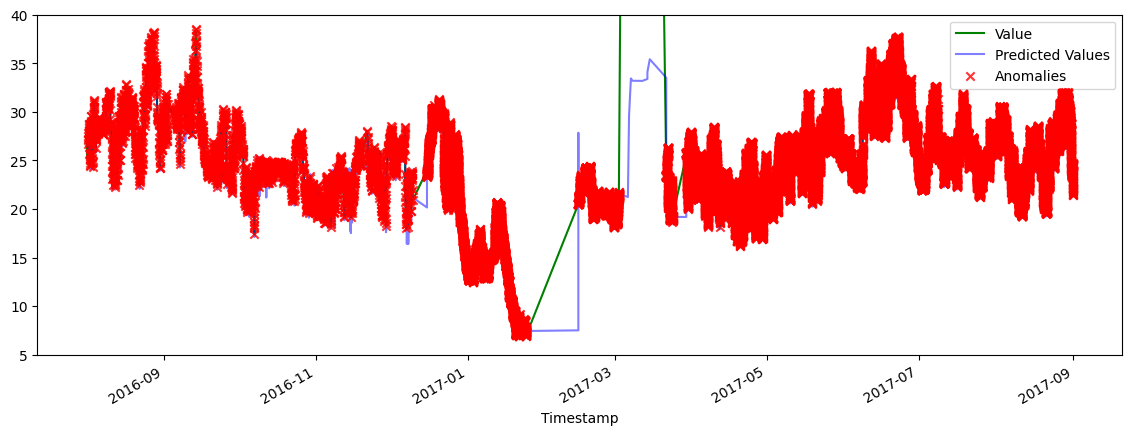

In [171]:
clusters = train_clusterer(result, result, IsolationForest(contamination=anoms_prop, random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: 5
8 predicted anomalies


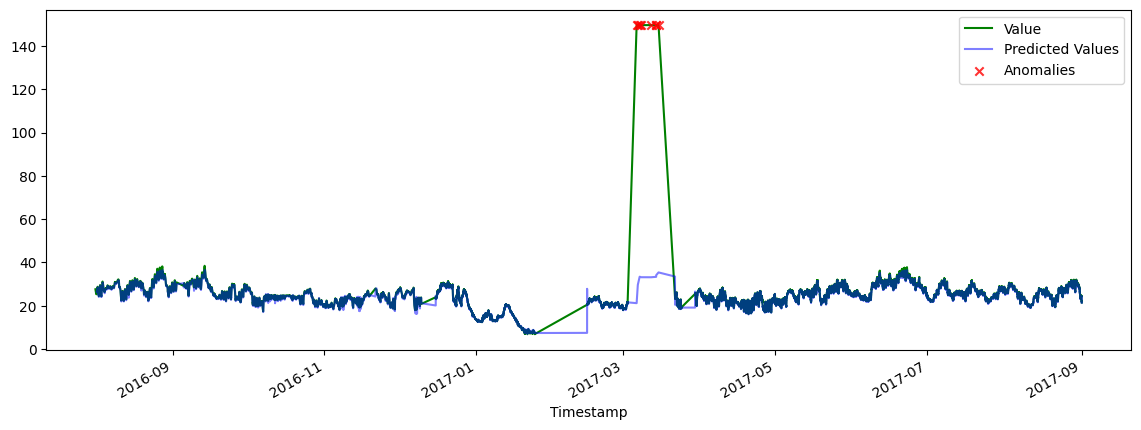

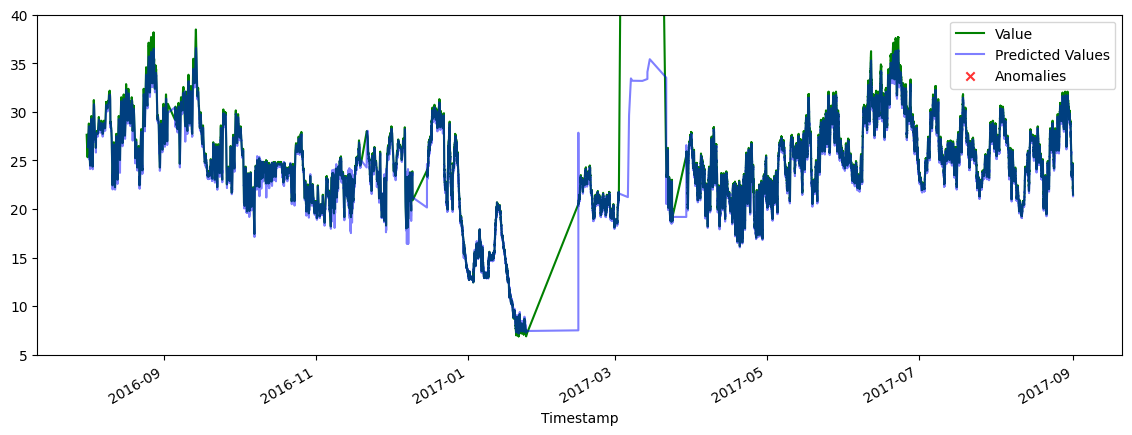

In [172]:
clusters = train_clusterer(result, result, KMeans(random_state=random_state))
plot_anoms_clustering(df, clusters, preds)

Anomalous cluster label: -1
56 predicted anomalies


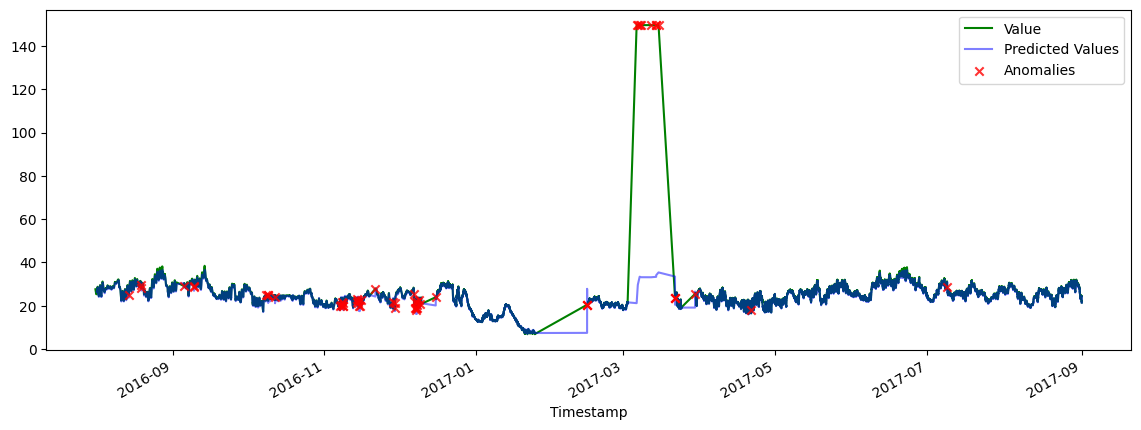

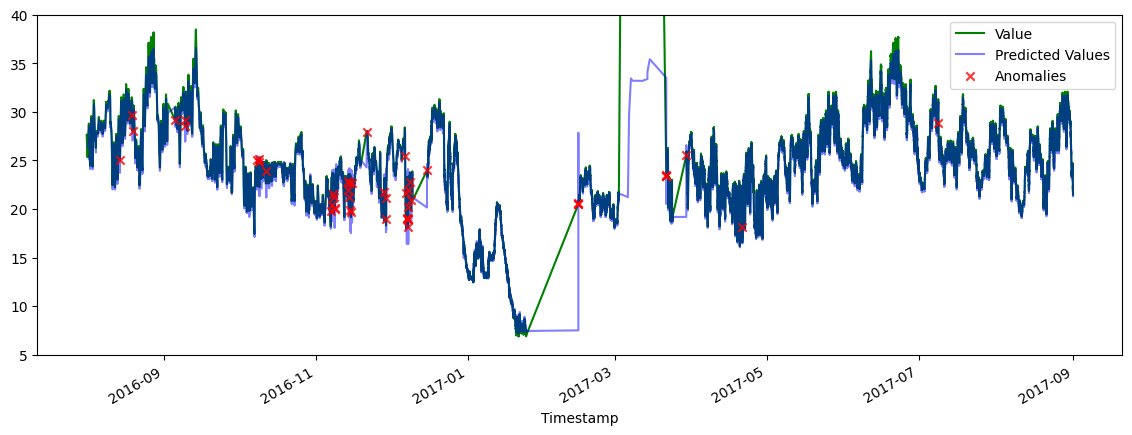

In [173]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(result)
plot_anoms_clustering(df, clusters, preds)